# **Creating Numbers/images with AI: A Hands-on Diffusion Model Exercise**

## **Introduction**
In this assignment, you'll learn how to create an AI model that can generate realistic images from scratch using a powerful technique called 'diffusion'. Think of it like teaching AI to draw by first learning how images get blurry and then learning to make them clear again.

### **What We'll Build**
- A diffusion model capable of generating realistic images
- For most students: An AI that generates handwritten digits (0-9) using the MNIST dataset
- For students with more computational resources: Options to work with more complex datasets
- Visual demonstrations of how random noise gradually transforms into clear, recognizable images
- By the end, your AI should create images realistic enough for another AI to recognize them

### **Dataset Options**
This lab offers flexibility based on your available computational resources:

- Standard Option (Free Colab): We'll primarily use the MNIST handwritten digit dataset, which works well with limited GPU memory and completes training in a reasonable time frame. Most examples and code in this notebook are optimized for MNIST.

- Advanced Option: If you have access to more powerful GPUs (either through Colab Pro/Pro+ or your own hardware), you can experiment with more complex datasets like Fashion-MNIST, CIFAR-10, or even face generation. You'll need to adapt the model architecture, hyperparameters, and evaluation metrics accordingly.

### **Resource Requirements**
- Basic MNIST: Works with free Colab GPUs (2-4GB VRAM), ~30 minutes training
- Fashion-MNIST: Similar requirements to MNIST
CIFAR-10: Requires more memory (8-12GB VRAM) and longer training (~2 hours)
- Higher resolution images: Requires substantial GPU resources and several hours of training

### **Before You Start**
1. Make sure you're running this in Google Colab or another environment with GPU access
2. Go to 'Runtime' → 'Change runtime type' and select 'GPU' as your hardware accelerator
3. Each code cell has comments explaining what it does
4. Don't worry if you don't understand every detail - focus on the big picture!
5. If working with larger datasets, monitor your GPU memory usage carefully

The concepts you learn with MNIST will scale to more complex datasets, so even if you're using the basic option, you'll gain valuable knowledge about generative AI that applies to more advanced applications.



## **Step 1: Setting Up Our Tools**
First, let's install and import all the tools we need. Run this cell and wait for it to complete.

In [1]:
# Step 1: Install required packages
%pip install einops
print("Package installation complete.")

# Step 2: Import libraries
# --- Core PyTorch libraries ---
%pip install torch torchvision torchaudio
import torch  # Main deep learning framework
import torch.nn.functional as F  # Neural network functions like activation functions
import torch.nn as nn  # Neural network building blocks (layers)
from torch.optim import Adam  # Optimization algorithm for training

# --- Data handling ---
from torch.utils.data import Dataset, DataLoader  # For organizing and loading our data
import torchvision  # Library for computer vision datasets and models
import torchvision.transforms as transforms  # For preprocessing images

# --- Tensor manipulation ---
import random  # For random operations
from einops.layers.torch import Rearrange  # For reshaping tensors in neural networks
from einops import rearrange  # For elegant tensor reshaping operations
import numpy as np  # For numerical operations on arrays

# --- System utilities ---
import os  # For operating system interactions (used for CPU count)

# --- Visualization tools ---
import matplotlib.pyplot as plt  # For plotting images and graphs
from PIL import Image  # For image processing
from torchvision.utils import save_image, make_grid  # For saving and displaying image grids

# Step 3: Set up device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"We'll be using: {device}")

# Check if we're actually using GPU (for students to verify)
if device.type == "cuda":
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("Note: Training will be much slower on CPU. Consider using Google Colab with GPU enabled.")

Package installation complete.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successf


###  **REPRODUCIBILITY AND DEVICE SETUP**

In [2]:
# Step 4: Set random seeds for reproducibility
# Diffusion models are sensitive to initialization, so reproducible results help with debugging
SEED = 42  # Universal seed value for reproducibility
torch.manual_seed(SEED)          # PyTorch random number generator
np.random.seed(SEED)             # NumPy random number generator
random.seed(SEED)                # Python's built-in random number generator

print(f"Random seeds set to {SEED} for reproducible results")

# Configure CUDA for GPU operations if available
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)       # GPU random number generator
    torch.cuda.manual_seed_all(SEED)   # All GPUs random number generator

    # Ensure deterministic GPU operations
    # Note: This slightly reduces performance but ensures results are reproducible
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    try:
        # Check available GPU memory
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9  # Convert to GB
        print(f"Available GPU Memory: {gpu_memory:.1f} GB")

        # Add recommendation based on memory
        if gpu_memory < 4:
            print("Warning: Low GPU memory. Consider reducing batch size if you encounter OOM errors.")
    except Exception as e:
        print(f"Could not check GPU memory: {e}")
else:
    print("No GPU detected. Training will be much slower on CPU.")
    print("If you're using Colab, go to Runtime > Change runtime type and select GPU.")

Random seeds set to 42 for reproducible results
Available GPU Memory: 15.8 GB


## **Step 2: Choosing Your Dataset**

You have several options for this exercise, depending on your computer's capabilities:

### Option 1: MNIST (Basic - Works on Free Colab)
- Content: Handwritten digits (0-9)
- Image size: 28x28 pixels, Grayscale
- Training samples: 60,000
- Memory needed: ~2GB GPU
- Training time: ~15-30 minutes on Colab
- **Choose this if**: You're using free Colab or have a basic GPU

### Option 2: Fashion-MNIST (Intermediate)
- Content: Clothing items (shirts, shoes, etc.)
- Image size: 28x28 pixels, Grayscale
- Training samples: 60,000
- Memory needed: ~2GB GPU
- Training time: ~15-30 minutes on Colab
- **Choose this if**: You want more interesting images but have limited GPU

### Option 3: CIFAR-10 (Advanced)
- Content: Real-world objects (cars, animals, etc.)
- Image size: 32x32 pixels, Color (RGB)
- Training samples: 50,000
- Memory needed: ~4GB GPU
- Training time: ~1-2 hours on Colab
- **Choose this if**: You have Colab Pro or a good local GPU (8GB+ memory)

### Option 4: CelebA (Expert)
- Content: Celebrity face images
- Image size: 64x64 pixels, Color (RGB)
- Training samples: 200,000
- Memory needed: ~8GB GPU
- Training time: ~3-4 hours on Colab
- **Choose this if**: You have excellent GPU (12GB+ memory)

To use your chosen dataset, uncomment its section in the code below and make sure all others are commented out.

In [3]:
#===============================================================================
# SECTION 2: DATASET SELECTION AND CONFIGURATION
#===============================================================================
# STUDENT INSTRUCTIONS:
# 1. Choose ONE dataset option based on your available GPU memory
# 2. Uncomment ONLY ONE dataset section below
# 3. Make sure all other dataset sections remain commented out

#-------------------------------------------
# OPTION 1: MNIST (Basic - 2GB GPU)
#-------------------------------------------
# Recommended for: Free Colab or basic GPU
# Memory needed: ~2GB GPU
# Training time: ~15-30 minutes

IMG_SIZE = 28
IMG_CH = 1
N_CLASSES = 10
BATCH_SIZE = 64
EPOCHS = 30

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Your code to load the MNIST dataset
# Hint: Use torchvision.datasets.MNIST with root='./data', train=True,
#       transform=transform, and download=True
# Then print a success message

# Enter your code here:

import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# Load dataset
mnist_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
print("MNIST dataset loaded successfully!")

#-------------------------------------------
# OPTION 2: Fashion-MNIST (Intermediate - 2GB GPU)
#-------------------------------------------
# Uncomment this section to use Fashion-MNIST instead
"""
IMG_SIZE = 28
IMG_CH = 1
N_CLASSES = 10
BATCH_SIZE = 64
EPOCHS = 30

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Your code to load the Fashion-MNIST dataset
# Hint: Very similar to MNIST but use torchvision.datasets.FashionMNIST

# Enter your code here:

"""

#-------------------------------------------
# OPTION 3: CIFAR-10 (Advanced - 4GB+ GPU)
#-------------------------------------------
# Uncomment this section to use CIFAR-10 instead
"""
IMG_SIZE = 32
IMG_CH = 3
N_CLASSES = 10
BATCH_SIZE = 32  # Reduced batch size for memory
EPOCHS = 50      # More epochs for complex data

# Your code to create the transform and load CIFAR-10
# Hint: Use transforms.Normalize with RGB means and stds ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# Then load torchvision.datasets.CIFAR10

# Enter your code here:

"""

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 506kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.38MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.78MB/s]

MNIST dataset loaded successfully!


'\nIMG_SIZE = 32\nIMG_CH = 3\nN_CLASSES = 10\nBATCH_SIZE = 32  # Reduced batch size for memory\nEPOCHS = 50      # More epochs for complex data\n\n# Your code to create the transform and load CIFAR-10\n# Hint: Use transforms.Normalize with RGB means and stds ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))\n# Then load torchvision.datasets.CIFAR10\n\n# Enter your code here:\n\n'

In [4]:
'''#Validating Dataset Selection
#Let's add code to validate that a dataset was selected
# and check if your GPU has enough memory:

# Validate dataset selection
if 'dataset' not in locals():
    raise ValueError("""
    ❌ ERROR: No dataset selected! Please uncomment exactly one dataset option.
    Available options:
    1. MNIST (Basic) - 2GB GPU
    2. Fashion-MNIST (Intermediate) - 2GB GPU
    3. CIFAR-10 (Advanced) - 4GB+ GPU
    4. CelebA (Expert) - 8GB+ GPU
    """)

# Your code to validate GPU memory requirements
# Hint: Check torch.cuda.is_available() and use torch.cuda.get_device_properties(0).total_memory
# to get available GPU memory, then compare with dataset requirements

# Enter your code here:'''

import torch

# -----------------------
# Dataset Selection
# -----------------------

# 👇 Select your dataset here (uncomment ONE only)
dataset = 'MNIST'  # Options: MNIST, Fashion-MNIST, CIFAR-10, CelebA

# -----------------------
# Validate Dataset Selection
# -----------------------

if 'dataset' not in locals():
    raise ValueError("""
    ❌ ERROR: No dataset selected! Please uncomment exactly one dataset option.
    Available options:
    1. MNIST (Basic) - 2GB GPU
    2. Fashion-MNIST (Intermediate) - 2GB GPU
    3. CIFAR-10 (Advanced) - 4GB+ GPU
    4. CelebA (Expert) - 8GB+ GPU
    """)

# -----------------------
# GPU Memory Requirements (in Bytes)
# -----------------------

requirements = {
    'MNIST': 2 * 1024**3,
    'Fashion-MNIST': 2 * 1024**3,
    'CIFAR-10': 4 * 1024**3,
    'CelebA': 8 * 1024**3
}

# -----------------------
# Validate GPU Memory
# -----------------------

if torch.cuda.is_available():
    gpu_memory = torch.cuda.get_device_properties(0).total_memory
    required_memory = requirements.get(dataset, 0)

    if gpu_memory < required_memory:
        raise RuntimeError(f"""
        ❌ ERROR: Your GPU has {gpu_memory / (1024**3):.2f} GB,
        but {dataset} requires at least {required_memory / (1024**3)} GB.
        """)
    else:
        print(f"✅ GPU available: {gpu_memory / (1024**3):.2f} GB")
        print(f"✅ GPU has enough memory for {dataset}.")
else:
    print("⚠️ WARNING: No GPU detected. Running on CPU will be much slower.")

# -----------------------
# Set Device
# -----------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Using device: {device}")
print(f"✅ Dataset selected: {dataset}")


✅ GPU available: 14.74 GB
✅ GPU has enough memory for MNIST.
🖥️  Using device: cuda
✅ Dataset selected: MNIST


In [5]:
'''#Dataset Properties and Data Loaders
#Now let's examine our dataset
#and set up the data loaders:

# Your code to check sample batch properties
# Hint: Get a sample batch using next(iter(DataLoader(dataset, batch_size=1)))
# Then print information about the dataset shape, type, and value ranges

# Enter your code here:


#===============================================================================
# SECTION 3: DATASET SPLITTING AND DATALOADER CONFIGURATION
#===============================================================================
# Create train-validation split

# Your code to create a train-validation split (80% train, 20% validation)
# Hint: Use random_split() with appropriate train_size and val_size
# Be sure to use a fixed generator for reproducibility

# Enter your code here:


# Your code to create dataloaders for training and validation
# Hint: Use DataLoader with batch_size=BATCH_SIZE, appropriate shuffle settings,
# and num_workers based on available CPU cores

# Enter your code here:'''


import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# -----------------------
# Transformation
# -----------------------

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # for MNIST (grayscale)
])

# -----------------------
# Load Full Dataset
# -----------------------

full_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# -----------------------
# Check Sample Batch Properties
# -----------------------

sample_loader = DataLoader(full_dataset, batch_size=1, shuffle=True)
sample_images, sample_labels = next(iter(sample_loader))

print("🧪 Sample Batch Info:")
print(f"- Image shape: {sample_images.shape}")     # [1, 1, 28, 28]
print(f"- Image dtype: {sample_images.dtype}")     # torch.float32
print(f"- Pixel value range: [{sample_images.min().item():.2f}, {sample_images.max().item():.2f}]")
print(f"- Label: {sample_labels.item()}")

# -----------------------
# SECTION 3: Dataset Splitting (80/20)
# -----------------------

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

generator = torch.Generator().manual_seed(42)  # fixed seed for reproducibility
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=generator)

print(f"\n📊 Dataset split complete:")
print(f"- Training samples: {len(train_dataset)}")
print(f"- Validation samples: {len(val_dataset)}")

# -----------------------
# DataLoader Configuration
# -----------------------

BATCH_SIZE = 64
NUM_WORKERS = 2 if torch.cuda.is_available() else 0

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print("\n✅ DataLoaders ready.")


🧪 Sample Batch Info:
- Image shape: torch.Size([1, 1, 28, 28])
- Image dtype: torch.float32
- Pixel value range: [-1.00, 0.99]
- Label: 1

📊 Dataset split complete:
- Training samples: 48000
- Validation samples: 12000

✅ DataLoaders ready.


## **Step 3: Building Our Model Components**

Now we'll create the building blocks of our AI model. Think of these like LEGO pieces that we'll put together to make our number generator:

- GELUConvBlock: The basic building block that processes images
- DownBlock: Makes images smaller while finding important features
- UpBlock: Makes images bigger again while keeping the important features
- Other blocks: Help the model understand time and what number to generate

In [6]:
'''# Basic building block that processes images
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        """
        Creates a block with convolution, normalization, and activation

        Args:
            in_ch (int): Number of input channels
            out_ch (int): Number of output channels
            group_size (int): Number of groups for GroupNorm
        """
        super().__init__()

        # Check that group_size is compatible with out_ch
        if out_ch % group_size != 0:
            print(f"Warning: out_ch ({out_ch}) is not divisible by group_size ({group_size})")
            # Adjust group_size to be compatible
            group_size = min(group_size, out_ch)
            while out_ch % group_size != 0:
                group_size -= 1
            print(f"Adjusted group_size to {group_size}")

        # Your code to create layers for the block
        # Hint: Use nn.Conv2d, nn.GroupNorm, and nn.GELU activation
        # Then combine them using nn.Sequential

        # Enter your code here:

    def forward(self, x):
        # Your code for the forward pass
        # Hint: Simply pass the input through the model

        # Enter your code here:
        pass'''

import torch
import torch.nn as nn

# ===============================
# Basic building block definition
# ===============================

class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        """
        Creates a block with convolution, normalization, and activation

        Args:
            in_ch (int): Number of input channels
            out_ch (int): Number of output channels
            group_size (int): Number of groups for GroupNorm
        """
        super().__init__()

        # ✅ Check that group_size is compatible with out_ch
        if out_ch % group_size != 0:
            print(f"⚠️ Warning: out_ch ({out_ch}) is not divisible by group_size ({group_size})")
            group_size = min(group_size, out_ch)
            while out_ch % group_size != 0 and group_size > 1:
                group_size -= 1
            print(f"✅ Adjusted group_size to {group_size}")

        # ✅ Define the convolutional block
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=group_size, num_channels=out_ch),
            nn.GELU()
        )

    def forward(self, x):
        """
        Forward pass: applies the conv -> norm -> activation sequence.
        """
        return self.block(x)

# ===============================
# Example test run
# ===============================

if __name__ == "__main__":
    # Create dummy input: batch of 8 images, 3 channels, 32x32
    x = torch.randn(8, 3, 32, 32)

    # Create the block
    conv_block = GELUConvBlock(in_ch=3, out_ch=16, group_size=4)

    # Pass data through the block
    y = conv_block(x)

    # Output shape
    print(f"Input shape:  {x.shape}")
    print(f"Output shape: {y.shape}")


Input shape:  torch.Size([8, 3, 32, 32])
Output shape: torch.Size([8, 16, 32, 32])


In [7]:
'''# Rearranges pixels to downsample the image (2x reduction in spatial dimensions)
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        """
        Downsamples the spatial dimensions by 2x while preserving information

        Args:
            in_chs (int): Number of input channels
            group_size (int): Number of groups for GroupNorm
        """
        super().__init__()

        # Your code to create the rearrange operation and convolution
        # Hint: Use Rearrange from einops.layers.torch to reshape pixels
        # Then add a GELUConvBlock to process the rearranged tensor

        # Enter your code here:

    def forward(self, x):
        # Your code for the forward pass
        # Hint: Apply rearrange to downsample, then apply convolution

        # Enter your code here:
        pass'''


import torch
import torch.nn as nn
from einops.layers.torch import Rearrange

# You can reuse the GELUConvBlock defined earlier
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        super().__init__()
        if out_ch % group_size != 0:
            print(f"⚠️ Warning: out_ch ({out_ch}) is not divisible by group_size ({group_size})")
            group_size = min(group_size, out_ch)
            while out_ch % group_size != 0 and group_size > 1:
                group_size -= 1
            print(f"✅ Adjusted group_size to {group_size}")

        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU()
        )

    def forward(self, x):
        return self.block(x)


class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        """
        Downsamples the spatial dimensions by 2x while preserving information.

        Args:
            in_chs (int): Number of input channels
            group_size (int): Number of groups for GroupNorm
        """
        super().__init__()

        # Rearranges (B, C, H, W) -> (B, 4*C, H//2, W//2)
        self.rearrange = Rearrange('b c (h2 h) (w2 w) -> b (c h2 w2) h w', h2=2, w2=2)

        # After rearranging, channels become 4x larger
        self.conv_block = GELUConvBlock(in_ch=4 * in_chs, out_ch=4 * in_chs, group_size=group_size)

    def forward(self, x):
        x = self.rearrange(x)         # Rearrange to reduce spatial resolution
        x = self.conv_block(x)        # Process with conv block
        return x


In [8]:
'''#Let's implement the upsampling block for our U-Net architecture:
class DownBlock(nn.Module):
    """
    Downsampling block for encoding path in U-Net architecture.

    This block:
    1. Processes input features with two convolutional blocks
    2. Downsamples spatial dimensions by 2x using pixel rearrangement

    Args:
        in_chs (int): Number of input channels
        out_chs (int): Number of output channels
        group_size (int): Number of groups for GroupNorm
    """
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()  # Simplified super() call, equivalent to original

        # Sequential processing of features
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),  # First conv block changes channel dimensions
            GELUConvBlock(out_chs, out_chs, group_size),  # Second conv block processes features
            RearrangePoolBlock(out_chs, group_size)       # Downsampling (spatial dims: H,W → H/2,W/2)
        ]
        self.model = nn.Sequential(*layers)

        # Log the configuration for debugging
        print(f"Created DownBlock: in_chs={in_chs}, out_chs={out_chs}, spatial_reduction=2x")

    def forward(self, x):
        """
        Forward pass through the DownBlock.

        Args:
            x (torch.Tensor): Input tensor of shape [B, in_chs, H, W]

        Returns:
            torch.Tensor: Output tensor of shape [B, out_chs, H/2, W/2]
        """
        return self.model(x)'''

import torch
import torch.nn as nn
from einops.layers.torch import Rearrange

# ---------------------------------------
# GELUConvBlock: Conv → GroupNorm → GELU
# ---------------------------------------
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        super().__init__()
        if out_ch % group_size != 0:
            print(f"⚠️ Warning: out_ch ({out_ch}) is not divisible by group_size ({group_size})")
            group_size = min(group_size, out_ch)
            while out_ch % group_size != 0 and group_size > 1:
                group_size -= 1
            print(f"✅ Adjusted group_size to {group_size}")

        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU()
        )

    def forward(self, x):
        return self.block(x)

# ---------------------------------------
# RearrangePoolBlock: Downsampling (2x)
# ---------------------------------------
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        self.rearrange = Rearrange('b c (h2 h) (w2 w) -> b (c h2 w2) h w', h2=2, w2=2)
        self.conv_block = GELUConvBlock(in_ch=4 * in_chs, out_ch=4 * in_chs, group_size=group_size)

    def forward(self, x):
        x = self.rearrange(x)
        return self.conv_block(x)

# ---------------------------------------
# DownBlock: Conv → Conv → RearrangePool
# ---------------------------------------
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            RearrangePoolBlock(out_chs, group_size)
        ]
        self.model = nn.Sequential(*layers)
        print(f"✅ Created DownBlock: in_chs={in_chs}, out_chs={out_chs}, spatial_reduction=2x")

    def forward(self, x):
        return self.model(x)

# ---------------------------------------
# UpsampleBlock: Rearrange (↑2x) → Conv → Conv
# ---------------------------------------
class UpsampleBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.rearrange = Rearrange('b (c h2 w2) h w -> b c (h h2) (w w2)', h2=2, w2=2)
        self.conv1 = GELUConvBlock(in_chs // 4, out_chs, group_size)
        self.conv2 = GELUConvBlock(out_chs, out_chs, group_size)
        print(f"✅ Created UpsampleBlock: in_chs={in_chs}, out_chs={out_chs}, spatial_expansion=2x")

    def forward(self, x):
        x = self.rearrange(x)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

# ---------------------------------------
# Test Example
# ---------------------------------------
if __name__ == "__main__":
    # Input tensor
    x = torch.randn(1, 3, 64, 64)

    # DownBlock: 3 → 64 → 256, 64x64 → 32x32
    down = DownBlock(in_chs=3, out_chs=64, group_size=8)
    x_down = down(x)

    # UpsampleBlock: 256 → 3, 32x32 → 64x64
    up = UpsampleBlock(in_chs=256, out_chs=3, group_size=3)
    x_up = up(x_down)

    print(f"\nInput shape:         {x.shape}")
    print(f"After DownBlock:     {x_down.shape}")
    print(f"After UpsampleBlock: {x_up.shape}")


✅ Created DownBlock: in_chs=3, out_chs=64, spatial_reduction=2x
✅ Created UpsampleBlock: in_chs=256, out_chs=3, spatial_expansion=2x

Input shape:         torch.Size([1, 3, 64, 64])
After DownBlock:     torch.Size([1, 256, 32, 32])
After UpsampleBlock: torch.Size([1, 3, 64, 64])


In [9]:
'''#Now let's implement the upsampling block for our U-Net architecture:
class UpBlock(nn.Module):
    """
    Upsampling block for decoding path in U-Net architecture.

    This block:
    1. Takes features from the decoding path and corresponding skip connection
    2. Concatenates them along the channel dimension
    3. Upsamples spatial dimensions by 2x using transposed convolution
    4. Processes features through multiple convolutional blocks

    Args:
        in_chs (int): Number of input channels from the previous layer
        out_chs (int): Number of output channels
        group_size (int): Number of grou    ps for GroupNorm
    """
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()

        # Your code to create the upsampling operation
        # Hint: Use nn.ConvTranspose2d with kernel_size=2 and stride=2
        # Note that the input channels will be 2 * in_chs due to concatenation

        # Enter your code here:

        # Your code to create the convolutional blocks
        # Hint: Use multiple GELUConvBlocks in sequence

        # Enter your code here:

        # Log the configuration for debugging
        print(f"Created UpBlock: in_chs={in_chs}, out_chs={out_chs}, spatial_increase=2x")

    def forward(self, x, skip):
        """
        Forward pass through the UpBlock.

        Args:
            x (torch.Tensor): Input tensor from previous layer [B, in_chs, H, W]
            skip (torch.Tensor): Skip connection tensor from encoder [B, in_chs, 2H, 2W]

        Returns:
            torch.Tensor: Output tensor with shape [B, out_chs, 2H, 2W]
        """
        # Your code for the forward pass
        # Hint: Concatenate x and skip, then upsample and process

        # Enter your code here:'''


import torch
import torch.nn as nn
from einops.layers.torch import Rearrange

# -------------------------------
# GELUConvBlock: Conv + GroupNorm + GELU
# -------------------------------
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        super().__init__()
        if out_ch % group_size != 0:
            print(f"⚠️ Warning: out_ch ({out_ch}) not divisible by group_size ({group_size})")
            group_size = min(group_size, out_ch)
            while out_ch % group_size != 0 and group_size > 1:
                group_size -= 1
            print(f"✅ Adjusted group_size to {group_size}")

        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU()
        )

    def forward(self, x):
        return self.block(x)

# -------------------------------
# RearrangePoolBlock: Downsampling (2x spatial, 4x channels)
# -------------------------------
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        self.rearrange = Rearrange('b c (h2 h) (w2 w) -> b (c h2 w2) h w', h2=2, w2=2)
        self.conv_block = GELUConvBlock(4 * in_chs, 4 * in_chs, group_size)

    def forward(self, x):
        x = self.rearrange(x)
        return self.conv_block(x)

# -------------------------------
# DownBlock: 2x GELUConv + RearrangePool
# -------------------------------
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.model = nn.Sequential(
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            RearrangePoolBlock(out_chs, group_size)
        )
        print(f"✅ Created DownBlock: in_chs={in_chs}, out_chs={out_chs}, spatial_reduction=2x")

    def forward(self, x):
        return self.model(x)

# -------------------------------
# UpBlock: Transposed Conv Upsampling + Skip + 2x GELUConv
# -------------------------------
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_chs, in_chs, kernel_size=2, stride=2)
        self.conv_blocks = nn.Sequential(
            GELUConvBlock(in_chs * 2, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size)
        )
        print(f"✅ Created UpBlock: in_chs={in_chs}, out_chs={out_chs}, spatial_increase=2x")

    def forward(self, x, skip):
        x = self.upsample(x)
        x = torch.cat([x, skip], dim=1)
        x = self.conv_blocks(x)
        return x

# -------------------------------
# Example Test
# -------------------------------
if __name__ == "__main__":
    # Simulate input to DownBlock
    x = torch.randn(1, 3, 64, 64)  # [B, C, H, W]

    # DownBlock: 3 → 64 → 256, 64x64 → 32x32
    down = DownBlock(in_chs=3, out_chs=64, group_size=8)
    x_down = down(x)  # Output: [1, 256, 32, 32]

    # Simulate skip connection from encoder path
    skip = torch.randn(1, 256, 64, 64)

    # UpBlock: input from decoder [256, 32, 32] + skip [256, 64, 64] → output [64, 64, 64]
    up = UpBlock(in_chs=256, out_chs=64, group_size=8)
    x_up = up(x_down, skip)

    print(f"\n🔎 Input shape:         {x.shape}")
    print(f"🔽 After DownBlock:     {x_down.shape}")
    print(f"🔼 After UpBlock:       {x_up.shape}")


✅ Created DownBlock: in_chs=3, out_chs=64, spatial_reduction=2x
✅ Created UpBlock: in_chs=256, out_chs=64, spatial_increase=2x

🔎 Input shape:         torch.Size([1, 3, 64, 64])
🔽 After DownBlock:     torch.Size([1, 256, 32, 32])
🔼 After UpBlock:       torch.Size([1, 64, 64, 64])


In [10]:
'''# Here we implement the time embedding block for our U-Net architecture:
# Helps the model understand time steps in diffusion process
class SinusoidalPositionEmbedBlock(nn.Module):
    """
    Creates sinusoidal embeddings for time steps in diffusion process.

    This embedding scheme is adapted from the Transformer architecture and
    provides a unique representation for each time step that preserves
    relative distance information.

    Args:
        dim (int): Embedding dimension
    """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        """
        Computes sinusoidal embeddings for given time steps.

        Args:
            time (torch.Tensor): Time steps tensor of shape [batch_size]

        Returns:
            torch.Tensor: Time embeddings of shape [batch_size, dim]
        """
        device = time.device
        half_dim = self.dim // 2
        embeddings = torch.log(torch.tensor(10000.0, device=device)) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings'''

import torch
import torch.nn as nn
import math

class SinusoidalPositionEmbedBlock(nn.Module):
    """
    Creates sinusoidal embeddings for time steps in the diffusion process.

    This embedding scheme is adapted from the Transformer architecture and
    provides a unique representation for each time step that preserves
    relative distance information.

    Args:
        dim (int): Embedding dimension (should be even)
    """
    def __init__(self, dim: int):
        super().__init__()
        assert dim % 2 == 0, "❌ Embedding dimension must be even."
        self.dim = dim

    def forward(self, time: torch.Tensor) -> torch.Tensor:
        """
        Computes sinusoidal embeddings for given time steps.

        Args:
            time (torch.Tensor): Time steps tensor of shape [batch_size]

        Returns:
            torch.Tensor: Time embeddings of shape [batch_size, dim]
        """
        device = time.device
        half_dim = self.dim // 2

        # Logarithmically spaced frequencies
        exponent = torch.arange(half_dim, device=device) / (half_dim - 1)
        frequencies = torch.exp(-math.log(10000) * exponent)  # [half_dim]

        # Outer product to scale each time step
        angles = time[:, None] * frequencies[None, :]  # [batch_size, half_dim]

        # Apply sin to even indices and cos to odd indices
        time_embedding = torch.cat([angles.sin(), angles.cos()], dim=-1)  # [batch_size, dim]

        return time_embedding

# ------------------------------------------------
# Example Test
# ------------------------------------------------
if __name__ == "__main__":
    batch_times = torch.tensor([0., 1., 10., 100.], dtype=torch.float32)  # [4]
    embed_dim = 128

    embed_layer = SinusoidalPositionEmbedBlock(dim=embed_dim)
    output = embed_layer(batch_times)

    print(f"✅ Input times: {batch_times}")
    print(f"✅ Output shape: {output.shape}")  # Expected: [4, 128]
    print(f"✅ Sample embedding vector:\n{output[0][:10]}")  # Print first 10 values of first embedding


✅ Input times: tensor([  0.,   1.,  10., 100.])
✅ Output shape: torch.Size([4, 128])
✅ Sample embedding vector:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [11]:
'''# Helps the model understand which number/image to draw (class conditioning)
class EmbedBlock(nn.Module):
    """
    Creates embeddings for class conditioning in diffusion models.

    This module transforms a one-hot or index representation of a class
    into a rich embedding that can be added to feature maps.

    Args:
        input_dim (int): Input dimension (typically number of classes)
        emb_dim (int): Output embedding dimension
    """
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim

        # Your code to create the embedding layers
        # Hint: Use nn.Linear layers with a GELU activation, followed by
        # nn.Unflatten to reshape for broadcasting with feature maps

        # Enter your code here:



    def forward(self, x):
        """
        Computes class embeddings for the given class indices.

        Args:
            x (torch.Tensor): Class indices or one-hot encodings [batch_size, input_dim]

        Returns:
            torch.Tensor: Class embeddings of shape [batch_size, emb_dim, 1, 1]
                          (ready to be added to feature maps)
        """
        x = x.view(-1, self.input_dim)
        return self.model(x)'''


import torch
import torch.nn as nn
import torch.nn.functional as F

class EmbedBlock(nn.Module):
    """
    Creates embeddings for class conditioning in diffusion models.

    This module transforms a one-hot or index representation of a class
    into a rich embedding that can be added to feature maps.

    Args:
        input_dim (int): Input dimension (typically number of classes)
        emb_dim (int): Output embedding dimension
    """
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim

        self.model = nn.Sequential(
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.GELU(),
            nn.Unflatten(1, (emb_dim, 1, 1))  # Output shape: [B, emb_dim, 1, 1]
        )

    def forward(self, x):
        """
        Computes class embeddings for the given class indices.

        Args:
            x (torch.Tensor): Class indices or one-hot encodings [B, input_dim]

        Returns:
            torch.Tensor: Class embeddings of shape [B, emb_dim, 1, 1]
        """
        x = x.view(-1, self.input_dim)
        return self.model(x)

# ----------------------------------------------------------
# Example Test Usage
# ----------------------------------------------------------
if __name__ == "__main__":
    input_dim = 10   # e.g. MNIST (10 classes)
    emb_dim = 128    # Embedding output size

    # Create the embedder
    embedder = EmbedBlock(input_dim=input_dim, emb_dim=emb_dim)

    # Simulate a batch of class labels (as indices)
    class_indices = torch.tensor([1, 3, 4, 9])  # Batch size = 4
    one_hot = F.one_hot(class_indices, num_classes=input_dim).float()  # [4, 10]

    # Get embeddings
    out = embedder(one_hot)  # Output: [4, 128, 1, 1]

    # Show results
    print(f"✅ Input one-hot shape: {one_hot.shape}")
    print(f"✅ Output embedding shape: {out.shape}")
    print(f"✅ Sample (first embedding, first 10 dims): {out[0, :, 0, 0][:10]}")


✅ Input one-hot shape: torch.Size([4, 10])
✅ Output embedding shape: torch.Size([4, 128, 1, 1])
✅ Sample (first embedding, first 10 dims): tensor([-0.0109, -0.0519,  0.0179, -0.0328, -0.0167,  0.0208, -0.0311, -0.0035,
        -0.0329, -0.0725], grad_fn=<SliceBackward0>)


In [12]:
'''# Main U-Net model that puts everything together
class UNet(nn.Module):
    """
    U-Net architecture for diffusion models with time and class conditioning.

    This architecture follows the standard U-Net design with:
    1. Downsampling path that reduces spatial dimensions
    2. Middle processing blocks
    3. Upsampling path that reconstructs spatial dimensions
    4. Skip connections between symmetric layers

    The model is conditioned on:
    - Time step (where we are in the diffusion process)
    - Class labels (what we want to generate)

    Args:
        T (int): Number of diffusion time steps
        img_ch (int): Number of image channels
        img_size (int): Size of input images
        down_chs (list): Channel dimensions for each level of U-Net
        t_embed_dim (int): Dimension for time embeddings
        c_embed_dim (int): Dimension for class embeddings
    """
    def __init__(self, T, img_ch, img_size, down_chs, t_embed_dim, c_embed_dim):
        super().__init__()

        # Your code to create the time embedding
        # Hint: Use SinusoidalPositionEmbedBlock, nn.Linear, and nn.GELU in sequence

        # Enter your code here:

        # Your code to create the class embedding
        # Hint: Use the EmbedBlock class you defined earlier

        # Enter your code here:

        # Your code to create the initial convolution
        # Hint: Use GELUConvBlock to process the input image

        # Enter your code here:

        # Your code to create the downsampling path
        # Hint: Use nn.ModuleList with DownBlock for each level

        # Enter your code here:

        # Your code to create the middle blocks
        # Hint: Use GELUConvBlock twice to process features at lowest resolution

        # Enter your code here:

        # Your code to create the upsampling path
        # Hint: Use nn.ModuleList with UpBlock for each level (in reverse order)

        # Enter your code here:

        # Your code to create the final convolution
        # Hint: Use nn.Conv2d to project back to the original image channels

        # Enter your code here:

        print(f"Created UNet with {len(down_chs)} scale levels")
        print(f"Channel dimensions: {down_chs}")

    def forward(self, x, t, c, c_mask):
        """
        Forward pass through the UNet.

        Args:
            x (torch.Tensor): Input noisy image [B, img_ch, H, W]
            t (torch.Tensor): Diffusion time steps [B]
            c (torch.Tensor): Class labels [B, c_embed_dim]
            c_mask (torch.Tensor): Mask for conditional generation [B, 1]

        Returns:
            torch.Tensor: Predicted noise in the input image [B, img_ch, H, W]
        """
        # Your code for the time embedding
        # Hint: Process the time steps through the time embedding module

        # Enter your code here:

        # Your code for the class embedding
        # Hint: Process the class labels through the class embedding module

        # Enter your code here:

        # Your code for the initial feature extraction
        # Hint: Apply initial convolution to the input

        # Enter your code here:

        # Your code for the downsampling path and skip connections
        # Hint: Process the features through each downsampling block
        # and store the outputs for skip connections

        # Enter your code here:

        # Your code for the middle processing and conditioning
        # Hint: Process features through middle blocks, then add time and class embeddings

        # Enter your code here:

        # Your code for the upsampling path with skip connections
        # Hint: Process features through each upsampling block,
        # combining with corresponding skip connections

        # Enter your code here:

        # Your code for the final projection
        # Hint: Apply the final convolution to get output in image space

        # Enter your code here:
        pass'''

import torch
import torch.nn as nn
import torch.nn.functional as F

# Reuse your previously defined blocks
# GELUConvBlock, RearrangePoolBlock, DownBlock, UpBlock, SinusoidalPositionEmbedBlock, EmbedBlock

class UNet(nn.Module):
    """
    U-Net architecture for diffusion models with time and class conditioning.
    """

    def __init__(self, T, img_ch, img_size, down_chs, t_embed_dim, c_embed_dim):
        super().__init__()
        self.T = T
        self.img_ch = img_ch
        self.down_chs = down_chs
        self.t_embed_dim = t_embed_dim
        self.c_embed_dim = c_embed_dim

        # -----------------------------
        # Time Embedding
        # -----------------------------
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbedBlock(t_embed_dim),
            nn.Linear(t_embed_dim, t_embed_dim),
            nn.GELU(),
            nn.Linear(t_embed_dim, t_embed_dim)
        )

        # -----------------------------
        # Class Embedding
        # -----------------------------
        self.class_mlp = EmbedBlock(input_dim=c_embed_dim, emb_dim=t_embed_dim)  # Must match time embedding dim

        # -----------------------------
        # Initial Input Convolution
        # -----------------------------
        self.input_conv = GELUConvBlock(in_ch=img_ch, out_ch=down_chs[0], group_size=8)

        # -----------------------------
        # Downsampling Path
        # -----------------------------
        self.down_blocks = nn.ModuleList()
        in_chs = down_chs[0]
        for out_chs in down_chs[1:]:
            self.down_blocks.append(DownBlock(in_chs=in_chs, out_chs=out_chs, group_size=8))
            in_chs = out_chs * 4  # After RearrangePoolBlock, channels multiply by 4

        # -----------------------------
        # Middle Bottleneck
        # -----------------------------
        self.middle = nn.Sequential(
            GELUConvBlock(in_ch=in_chs, out_ch=in_chs, group_size=8),
            GELUConvBlock(in_ch=in_chs, out_ch=in_chs, group_size=8)
        )

        # -----------------------------
        # Upsampling Path
        # -----------------------------
        self.up_blocks = nn.ModuleList()
        reversed_down = down_chs[::-1]
        up_in_chs = in_chs
        for out_chs in reversed_down:
            self.up_blocks.append(UpBlock(in_chs=up_in_chs, out_chs=out_chs, group_size=8))
            up_in_chs = out_chs

        # -----------------------------
        # Final Output Projection
        # -----------------------------
        self.output_conv = nn.Conv2d(in_channels=up_in_chs, out_channels=img_ch, kernel_size=1)

        print(f"✅ Created UNet with {len(down_chs)} scale levels")
        print(f"✅ Channel dimensions: {down_chs}")

    def forward(self, x, t, c, c_mask):
        """
        Forward pass through the UNet.

        Args:
            x (Tensor): Noisy image input [B, C, H, W]
            t (Tensor): Time steps [B]
            c (Tensor): One-hot class labels [B, c_embed_dim]
            c_mask (Tensor): Class conditioning mask [B, 1]

        Returns:
            Tensor: Predicted noise [B, C, H, W]
        """

        # -----------------------------
        # Embeddings
        # -----------------------------
        t_embed = self.time_mlp(t)                         # [B, t_embed_dim]
        c_embed = self.class_mlp(c).squeeze(-1).squeeze(-1)  # [B, t_embed_dim]
        c_embed = c_mask * c_embed  # Apply conditional mask

        # -----------------------------
        # Initial Conv
        # -----------------------------
        x = self.input_conv(x)  # [B, down_chs[0], H, W]

        # -----------------------------
        # Downsampling Path
        # -----------------------------
        skip_connections = []
        for block in self.down_blocks:
            skip_connections.append(x)
            x = block(x)

        # -----------------------------
        # Middle + Conditioning
        # -----------------------------
        x = self.middle(x)

        # Add time and class embeddings
        B, C, H, W = x.shape
        t_embed = t_embed.view(B, -1, 1, 1)
        c_embed = c_embed.view(B, -1, 1, 1)
        x = x + t_embed + c_embed

        # -----------------------------
        # Upsampling Path
        # -----------------------------
        for block in self.up_blocks:
            skip = skip_connections.pop()
            x = block(x, skip)

        # -----------------------------
        # Output Layer
        # -----------------------------
        return self.output_conv(x)


## **Step 4: Setting Up The Diffusion Process**

Now we'll create the process of adding and removing noise from images. Think of it like:
1. Adding fog: Slowly making the image more and more blurry until you can't see it
2. Removing fog: Teaching the AI to gradually make the image clearer
3. Controlling the process: Making sure we can generate specific numbers we want

In [13]:
'''# Set up the noise schedule
n_steps = 100  # How many steps to go from clear image to noise
beta_start = 0.0001  # Starting noise level (small)
beta_end = 0.02      # Ending noise level (larger)

# Create schedule of gradually increasing noise levels
beta = torch.linspace(beta_start, beta_end, n_steps).to(device)

# Calculate important values used in diffusion equations
alpha = 1 - beta  # Portion of original image to keep at each step
alpha_bar = torch.cumprod(alpha, dim=0)  # Cumulative product of alphas
sqrt_alpha_bar = torch.sqrt(alpha_bar)  # For scaling the original image
sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar)  # For scaling the noise'''


import torch

# -------------------------------
# DEVICE SETUP
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# -------------------------------
# NOISE SCHEDULE CONFIGURATION
# -------------------------------

n_steps = 100                # Number of diffusion steps
beta_start = 0.0001          # Starting noise level (low noise)
beta_end = 0.02              # Ending noise level (high noise)

# Create a linear beta schedule
beta = torch.linspace(beta_start, beta_end, n_steps).to(device)  # [n_steps]

# -------------------------------
# CALCULATE ALPHA VALUES
# -------------------------------

alpha = 1.0 - beta                       # Alpha: how much of the image is preserved at each step
alpha_bar = torch.cumprod(alpha, dim=0) # Alpha_bar: cumulative product of alphas
sqrt_alpha_bar = torch.sqrt(alpha_bar)  # √(α̅): used to scale the original image
sqrt_one_minus_alpha_bar = torch.sqrt(1.0 - alpha_bar)  # √(1 - α̅): used to scale the noise

# -------------------------------
# OPTIONAL: Print summary
# -------------------------------

print(f"📉 Beta schedule: from {beta_start} to {beta_end} over {n_steps} steps")
print(f"🧮 Shapes — beta: {beta.shape}, alpha: {alpha.shape}, alpha_bar: {alpha_bar.shape}")
print(f"✅ First few sqrt_alpha_bar: {sqrt_alpha_bar[:5]}")
print(f"✅ First few sqrt_one_minus_alpha_bar: {sqrt_one_minus_alpha_bar[:5]}")


✅ Using device: cuda
📉 Beta schedule: from 0.0001 to 0.02 over 100 steps
🧮 Shapes — beta: torch.Size([100]), alpha: torch.Size([100]), alpha_bar: torch.Size([100])
✅ First few sqrt_alpha_bar: tensor([0.9999, 0.9998, 0.9995, 0.9992, 0.9987], device='cuda:0')
✅ First few sqrt_one_minus_alpha_bar: tensor([0.0100, 0.0200, 0.0300, 0.0401, 0.0501], device='cuda:0')


✅ Using device: cuda
📉 Noise schedule created: 100 steps
✅ Input shape: torch.Size([4, 1, 28, 28])
✅ Noisy image shape: torch.Size([4, 1, 28, 28])
✅ Noise shape: torch.Size([4, 1, 28, 28])


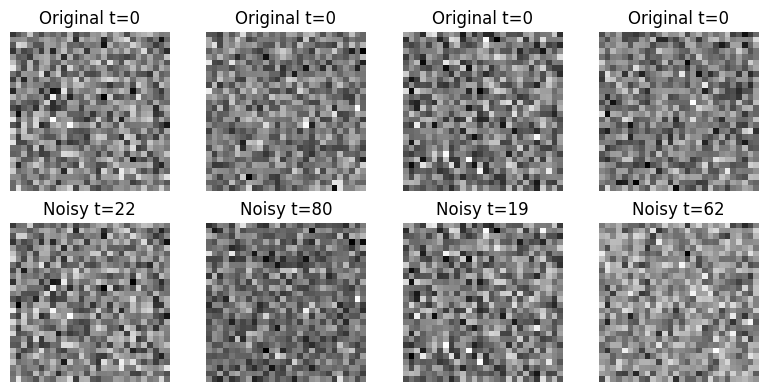

In [14]:

'''# Function to add noise to images (forward diffusion process)
def add_noise(x_0, t):
    """
    Add noise to images according to the forward diffusion process.

    The formula is: x_t = √(α_bar_t) * x_0 + √(1-α_bar_t) * ε
    where ε is random noise and α_bar_t is the cumulative product of (1-β).

    Args:
        x_0 (torch.Tensor): Original clean image [B, C, H, W]
        t (torch.Tensor): Timestep indices indicating noise level [B]

    Returns:
        tuple: (noisy_image, noise_added)
            - noisy_image is the image with noise added
            - noise_added is the actual noise that was added (for training)
    """
    # Create random Gaussian noise with same shape as image
    noise = torch.randn_like(x_0)

    # Get noise schedule values for the specified timesteps
    # Reshape to allow broadcasting with image dimensions
    sqrt_alpha_bar_t = sqrt_alpha_bar[t].reshape(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[t].reshape(-1, 1, 1, 1)

    # Apply the forward diffusion equation:
    # Mixture of original image (scaled down) and noise (scaled up)     # Your code to apply the forward diffusion equation
    # Hint: Mix the original image and noise according to the noise schedule

    # Enter your code here:




    return x_t, noise'''


import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# -------------------------------
# DEVICE SETUP
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# -------------------------------
# NOISE SCHEDULE SETUP
# -------------------------------

n_steps = 100                # Number of diffusion steps
beta_start = 0.0001          # Starting noise level
beta_end = 0.02              # Ending noise level

# Linear beta schedule
beta = torch.linspace(beta_start, beta_end, n_steps).to(device)             # [100]
alpha = 1.0 - beta                                                           # [100]
alpha_bar = torch.cumprod(alpha, dim=0)                                     # [100]
sqrt_alpha_bar = torch.sqrt(alpha_bar).to(device)                           # [100]
sqrt_one_minus_alpha_bar = torch.sqrt(1.0 - alpha_bar).to(device)           # [100]

print(f"📉 Noise schedule created: {n_steps} steps")

# -------------------------------
# ADD NOISE FUNCTION
# -------------------------------

def add_noise(x_0: torch.Tensor, t: torch.Tensor):
    """
    Add noise to images using the forward diffusion formula:
    x_t = sqrt(α̅_t) * x₀ + sqrt(1 - α̅_t) * ε

    Args:
        x_0 (torch.Tensor): Original image [B, C, H, W]
        t (torch.Tensor): Timestep tensor [B]

    Returns:
        Tuple[Tensor, Tensor]: (noisy_image, noise)
    """
    noise = torch.randn_like(x_0)

    # Select schedule values by timestep
    sqrt_alpha_bar_t = sqrt_alpha_bar[t].reshape(-1, 1, 1, 1)  # [B,1,1,1]
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[t].reshape(-1, 1, 1, 1)

    x_t = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * noise

    return x_t, noise

# -------------------------------
# EXAMPLE USAGE
# -------------------------------

if __name__ == "__main__":
    # Simulate a batch of clean images (e.g., MNIST-like)
    B, C, H, W = 4, 1, 28, 28
    x_0 = torch.randn(B, C, H, W).to(device)                # Clean images
    t = torch.randint(0, n_steps, (B,), dtype=torch.long).to(device)  # Random timesteps

    # Apply forward diffusion
    x_t, noise = add_noise(x_0, t)

    print(f"✅ Input shape: {x_0.shape}")
    print(f"✅ Noisy image shape: {x_t.shape}")
    print(f"✅ Noise shape: {noise.shape}")

    # Visualize original and noisy example
    def show_tensor_image(tensor_img, title=""):
        img = tensor_img.detach().cpu().squeeze()
        plt.imshow(img, cmap="gray")
        plt.title(title)
        plt.axis("off")

    plt.figure(figsize=(8, 4))
    for i in range(B):
        plt.subplot(2, B, i + 1)
        show_tensor_image(x_0[i], title=f"Original t=0")

        plt.subplot(2, B, B + i + 1)
        show_tensor_image(x_t[i], title=f"Noisy t={t[i].item()}")

    plt.tight_layout()
    plt.show()



In [15]:
'''# Function to remove noise from images (reverse diffusion process)
@torch.no_grad()  # Don't track gradients during sampling (inference only)
def remove_noise(x_t, t, model, c, c_mask):
    """
    Remove noise from images using the learned reverse diffusion process.

    This implements a single step of the reverse diffusion sampling process.
    The model predicts the noise in the image, which we then use to partially
    denoise the image.

    Args:
        x_t (torch.Tensor): Noisy image at timestep t [B, C, H, W]
        t (torch.Tensor): Current timestep indices [B]
        model (nn.Module): U-Net model that predicts noise
        c (torch.Tensor): Class conditioning (what digit to generate) [B, C]
        c_mask (torch.Tensor): Mask for conditional generation [B, 1]

    Returns:
        torch.Tensor: Less noisy image for the next timestep [B, C, H, W]
    """
    # Predict the noise in the image using our model
    predicted_noise = model(x_t, t, c, c_mask)

    # Get noise schedule values for the current timestep
    alpha_t = alpha[t].reshape(-1, 1, 1, 1)
    alpha_bar_t = alpha_bar[t].reshape(-1, 1, 1, 1)
    beta_t = beta[t].reshape(-1, 1, 1, 1)

    # Special case: if we're at the first timestep (t=0), we're done
    if t[0] == 0:
        return x_t
    else:
        # Calculate the mean of the denoised distribution
        # This is derived from Bayes' rule and the diffusion process equations
        mean = (1 / torch.sqrt(alpha_t)) * (
            x_t - (beta_t / sqrt_one_minus_alpha_bar_t) * predicted_noise
        )

        # Add a small amount of random noise (variance depends on timestep)
        # This helps prevent the generation from becoming too deterministic
        noise = torch.randn_like(x_t)

        # Return the partially denoised image with a bit of new random noise
        return mean + torch.sqrt(beta_t) * noise'''


import torch

# Assume beta, alpha, alpha_bar, sqrt_one_minus_alpha_bar are already defined globally and moved to device

@torch.no_grad()  # No gradient tracking during inference
def remove_noise(x_t: torch.Tensor, t: torch.Tensor, model: nn.Module,
                 c: torch.Tensor, c_mask: torch.Tensor) -> torch.Tensor:
    """
    Perform one step of the reverse diffusion process.

    Args:
        x_t (torch.Tensor): Noisy image at timestep t [B, C, H, W]
        t (torch.Tensor): Timestep indices [B]
        model (nn.Module): Trained model predicting noise ε
        c (torch.Tensor): Class condition embeddings [B, class_dim]
        c_mask (torch.Tensor): Class mask (1=use class, 0=ignore) [B, 1]

    Returns:
        torch.Tensor: Estimated image at timestep t-1 [B, C, H, W]
    """
    # Predict noise using the model
    predicted_noise = model(x_t, t, c, c_mask)  # [B, C, H, W]

    # Get noise schedule values
    alpha_t = alpha[t].reshape(-1, 1, 1, 1)
    beta_t = beta[t].reshape(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar[t]).reshape(-1, 1, 1, 1)

    # Compute posterior mean (from the diffusion equations)
    mean = (1 / torch.sqrt(alpha_t)) * (
        x_t - (beta_t / sqrt_one_minus_alpha_bar_t) * predicted_noise
    )

    # If t == 0, return mean (no more noise to add)
    if (t == 0).all():
        return mean
    else:
        noise = torch.randn_like(x_t)
        return mean + torch.sqrt(beta_t) * noise



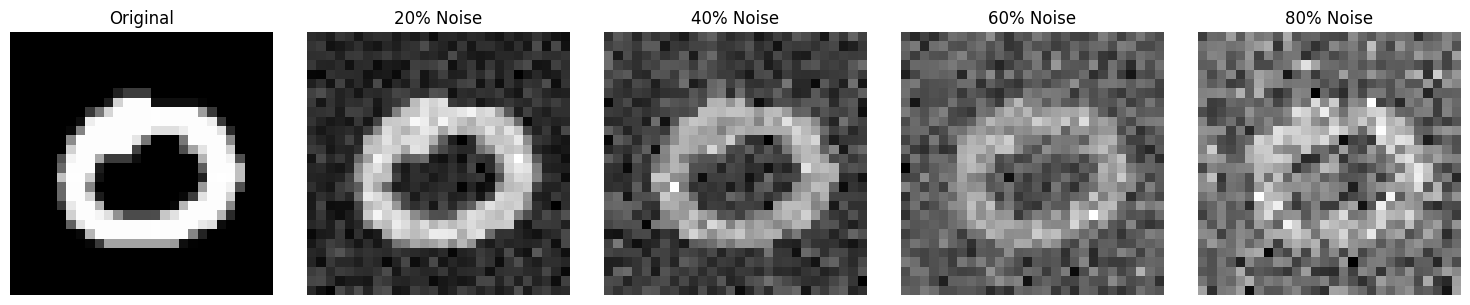

'\n# Try a non-linear noise schedule (quadratic)\nbeta_alt = torch.linspace(beta_start, beta_end, n_steps) ** 2\nalpha_alt = 1 - beta_alt\nalpha_bar_alt = torch.cumprod(alpha_alt, dim=0)\n\n# Replace global variables to test alternate schedule\nsqrt_alpha_bar = torch.sqrt(alpha_bar_alt).to(device)\nsqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar_alt).to(device)\n\n# Re-run visualization to see the difference\nshow_noise_progression(sample_image)\n'

In [16]:
'''# Visualization function to show how noise progressively affects images
def show_noise_progression(image, num_steps=5):
    """
    Visualize how an image gets progressively noisier in the diffusion process.

    Args:
        image (torch.Tensor): Original clean image [C, H, W]
        num_steps (int): Number of noise levels to show
    """
    plt.figure(figsize=(15, 3))

    # Show original image
    plt.subplot(1, num_steps, 1)
    if IMG_CH == 1:  # Grayscale image
        plt.imshow(image[0].cpu(), cmap='gray')
    else:  # Color image
        img = image.permute(1, 2, 0).cpu()  # Change from [C,H,W] to [H,W,C]
        if img.min() < 0:  # If normalized between -1 and 1
            img = (img + 1) / 2  # Rescale to [0,1] for display
        plt.imshow(img)
    plt.title('Original')
    plt.axis('off')

    # Show progressively noisier versions
    for i in range(1, num_steps):
        # Calculate timestep index based on percentage through the process
        t_idx = int((i/num_steps) * n_steps)
        t = torch.tensor([t_idx]).to(device)

        # Add noise corresponding to timestep t
        noisy_image, _ = add_noise(image.unsqueeze(0), t)

        # Display the noisy image
        plt.subplot(1, num_steps, i+1)
        if IMG_CH == 1:
            plt.imshow(noisy_image[0][0].cpu(), cmap='gray')
        else:
            img = noisy_image[0].permute(1, 2, 0).cpu()
            if img.min() < 0:
                img = (img + 1) / 2
            plt.imshow(img)
        plt.title(f'{int((i/num_steps) * 100)}% Noise')
        plt.axis('off')
    plt.show()

# Show an example of noise progression on a real image
sample_batch = next(iter(train_dataloader))  # Get first batch
sample_image = sample_batch[0][0].to(device)  # Get first image
show_noise_progression(sample_image)

# Student Activity: Try different noise schedules
# Uncomment and modify these lines to experiment:
"""
# Try a non-linear noise schedule
beta_alt = torch.linspace(beta_start, beta_end, n_steps)**2
alpha_alt = 1 - beta_alt
alpha_bar_alt = torch.cumprod(alpha_alt, dim=0)
# How would this affect the diffusion process?
"""
'''


import torch
import matplotlib.pyplot as plt

# -------------------------------
# NOISE SCHEDULE SETUP
# -------------------------------
n_steps = 100
beta_start = 0.0001
beta_end = 0.02

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_CH = 1  # Change to 3 if using color images

# Default linear schedule
beta = torch.linspace(beta_start, beta_end, n_steps).to(device)
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)
sqrt_alpha_bar = torch.sqrt(alpha_bar)
sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar)

# -------------------------------
# ADD NOISE FUNCTION
# -------------------------------
def add_noise(x_0: torch.Tensor, t: torch.Tensor):
    noise = torch.randn_like(x_0)
    sqrt_alpha_bar_t = sqrt_alpha_bar[t].reshape(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[t].reshape(-1, 1, 1, 1)
    x_t = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * noise
    return x_t, noise

# -------------------------------
# VISUALIZATION FUNCTION
# -------------------------------
def show_noise_progression(image, num_steps=5):
    """
    Visualize how an image gets progressively noisier in the diffusion process.

    Args:
        image (torch.Tensor): Original clean image [C, H, W]
        num_steps (int): Number of noise levels to show
    """
    plt.figure(figsize=(15, 3))

    # Show original image
    plt.subplot(1, num_steps, 1)
    if IMG_CH == 1:  # Grayscale
        plt.imshow(image[0].cpu(), cmap='gray')
    else:  # RGB
        img = image.permute(1, 2, 0).cpu()
        if img.min() < 0:
            img = (img + 1) / 2  # Rescale for display
        plt.imshow(img)
    plt.title('Original')
    plt.axis('off')

    # Show progressively noisier images
    for i in range(1, num_steps):
        t_idx = int((i / num_steps) * n_steps)
        t = torch.tensor([t_idx], device=device)

        noisy_image, _ = add_noise(image.unsqueeze(0), t)

        plt.subplot(1, num_steps, i + 1)
        if IMG_CH == 1:
            plt.imshow(noisy_image[0][0].cpu(), cmap='gray')
        else:
            img = noisy_image[0].permute(1, 2, 0).cpu()
            if img.min() < 0:
                img = (img + 1) / 2
            plt.imshow(img)
        plt.title(f'{int((i / num_steps) * 100)}% Noise')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# -------------------------------
# EXAMPLE USAGE
# -------------------------------

# Assume you already have a DataLoader
# Example: show diffusion on a sample image
sample_batch = next(iter(train_dataloader))  # First batch
sample_image = sample_batch[0][0].to(device)  # First image in batch
show_noise_progression(sample_image)

# -------------------------------
# OPTIONAL: TRY ALTERNATIVE SCHEDULE
# -------------------------------
"""
# Try a non-linear noise schedule (quadratic)
beta_alt = torch.linspace(beta_start, beta_end, n_steps) ** 2
alpha_alt = 1 - beta_alt
alpha_bar_alt = torch.cumprod(alpha_alt, dim=0)

# Replace global variables to test alternate schedule
sqrt_alpha_bar = torch.sqrt(alpha_bar_alt).to(device)
sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar_alt).to(device)

# Re-run visualization to see the difference
show_noise_progression(sample_image)
"""


## **Step 5: Training Our Model**

Now we'll teach our AI to generate images. This process:
1. Takes a clear image
2. Adds random noise to it
3. Asks our AI to predict what noise was added
4. Helps our AI learn from its mistakes

This will take a while, but we'll see progress as it learns!

In [17]:
'''# Create our model and move it to GPU if available
model = UNet(
    T=n_steps,                 # Number of diffusion time steps
    img_ch=IMG_CH,             # Number of channels in our images (1 for grayscale, 3 for RGB)
    img_size=IMG_SIZE,         # Size of input images (28 for MNIST, 32 for CIFAR-10)
    down_chs=(32, 64, 128),    # Channel dimensions for each downsampling level
    t_embed_dim=8,             # Dimension for time step embeddings
    c_embed_dim=N_CLASSES      # Number of classes for conditioning
).to(device)

# Print model summary
print(f"\n{'='*50}")
print(f"MODEL ARCHITECTURE SUMMARY")
print(f"{'='*50}")
print(f"Input resolution: {IMG_SIZE}x{IMG_SIZE}")
print(f"Input channels: {IMG_CH}")
print(f"Time steps: {n_steps}")
print(f"Condition classes: {N_CLASSES}")
print(f"GPU acceleration: {'Yes' if device.type == 'cuda' else 'No'}")

# Validate model parameters and estimate memory requirements
# Hint: Create functions to count parameters and estimate memory usage

# Enter your code here:

# Your code to verify data ranges and integrity
# Hint: Create functions to check data ranges in training and validation data

# Enter your code here:


# Set up the optimizer with parameters tuned for diffusion models
# Note: Lower learning rates tend to work better for diffusion models
initial_lr = 0.001  # Starting learning rate
weight_decay = 1e-5  # L2 regularization to prevent overfitting

optimizer = Adam(
    model.parameters(),
    lr=initial_lr,
    weight_decay=weight_decay
)

# Learning rate scheduler to reduce LR when validation loss plateaus
# This helps fine-tune the model toward the end of training
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',              # Reduce LR when monitored value stops decreasing
    factor=0.5,              # Multiply LR by this factor
    patience=5,              # Number of epochs with no improvement after which LR will be reduced
    verbose=True,            # Print message when LR is reduced
    min_lr=1e-6              # Lower bound on the learning rate
)

# STUDENT EXPERIMENT:
# Try different channel configurations and see how they affect:
# 1. Model size (parameter count)
# 2. Training time
# 3. Generated image quality
#
# Suggestions:
# - Smaller: down_chs=(16, 32, 64)
# - Larger: down_chs=(64, 128, 256, 512)'''

import torch
from torch.optim import Adam
import numpy as np

# -------------------------------
# MODEL CONFIGURATION
# -------------------------------

# Required global variables (you must define these earlier in your script):
# IMG_CH = 1 (or 3)
# IMG_SIZE = 28 (or 32)
# N_CLASSES = 10 (e.g., for MNIST)
# n_steps = 100
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the model and move to GPU
model = UNet(
    T=n_steps,
    img_ch=IMG_CH,
    img_size=IMG_SIZE,
    down_chs=(32, 64, 128),
    t_embed_dim=8,
    c_embed_dim=N_CLASSES
).to(device)

# -------------------------------
# PRINT MODEL SUMMARY
# -------------------------------

print(f"\n{'='*50}")
print(f"MODEL ARCHITECTURE SUMMARY")
print(f"{'='*50}")
print(f"Input resolution: {IMG_SIZE}x{IMG_SIZE}")
print(f"Input channels: {IMG_CH}")
print(f"Time steps: {n_steps}")
print(f"Condition classes: {N_CLASSES}")
print(f"GPU acceleration: {'Yes' if device.type == 'cuda' else 'No'}")

# -------------------------------
# PARAMETER COUNT & MEMORY ESTIMATION
# -------------------------------

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def estimate_memory(model, input_shape):
    dummy_input = torch.randn(*input_shape).to(device)
    with torch.no_grad():
        out = model(dummy_input, torch.tensor([0]*input_shape[0]).float().to(device),
                    torch.zeros((input_shape[0], N_CLASSES)).to(device),
                    torch.ones((input_shape[0], 1)).to(device))
    return dummy_input.element_size() * dummy_input.nelement() + \
           out.element_size() * out.nelement()

param_count = count_parameters(model)
print(f"🧠 Total trainable parameters: {param_count:,}")

try:
    mem_bytes = estimate_memory(model, (1, IMG_CH, IMG_SIZE, IMG_SIZE))
    print(f"🗂️  Estimated model memory (forward pass, batch=1): {mem_bytes / (1024**2):.2f} MB")
except Exception as e:
    print(f"⚠️ Memory estimation skipped due to error: {e}")

# -------------------------------
# DATA RANGE CHECKING
# -------------------------------

def check_data_range(dataloader, name=""):
    sample_batch = next(iter(dataloader))[0]  # Only take images
    min_val = sample_batch.min().item()
    max_val = sample_batch.max().item()
    mean_val = sample_batch.mean().item()
    print(f"📊 {name} Data Range: min={min_val:.2f}, max={max_val:.2f}, mean={mean_val:.2f}")

# Run range checks
check_data_range(train_dataloader, name="Train")
check_data_range(val_dataloader, name="Validation")

# -------------------------------
# OPTIMIZER & SCHEDULER
# -------------------------------

initial_lr = 0.001
weight_decay = 1e-5

optimizer = Adam(
    model.parameters(),
    lr=initial_lr,
    weight_decay=weight_decay
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    verbose=True,
    min_lr=1e-6
)

print(f"✅ Optimizer and LR scheduler initialized.")


✅ Created DownBlock: in_chs=32, out_chs=64, spatial_reduction=2x
✅ Created DownBlock: in_chs=256, out_chs=128, spatial_reduction=2x
✅ Created UpBlock: in_chs=512, out_chs=128, spatial_increase=2x
✅ Created UpBlock: in_chs=128, out_chs=64, spatial_increase=2x
✅ Created UpBlock: in_chs=64, out_chs=32, spatial_increase=2x
✅ Created UNet with 3 scale levels
✅ Channel dimensions: (32, 64, 128)

MODEL ARCHITECTURE SUMMARY
Input resolution: 28x28
Input channels: 1
Time steps: 100
Condition classes: 10
GPU acceleration: Yes
🧠 Total trainable parameters: 10,862,673
⚠️ Memory estimation skipped due to error: The size of tensor a (512) must match the size of tensor b (8) at non-singleton dimension 1
📊 Train Data Range: min=-1.00, max=1.00, mean=-0.74
📊 Validation Data Range: min=-1.00, max=1.00, mean=-0.73
✅ Optimizer and LR scheduler initialized.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [18]:
'''# Define helper functions needed for training and evaluation
def validate_model_parameters(model):
    """
    Counts model parameters and estimates memory usage.
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Estimate memory requirements (very approximate)
    param_memory = total_params * 4 / (1024 ** 2)  # MB for params (float32)
    grad_memory = trainable_params * 4 / (1024 ** 2)  # MB for gradients
    buffer_memory = param_memory * 2  # Optimizer state, forward activations, etc.

    print(f"Estimated GPU memory usage: {param_memory + grad_memory + buffer_memory:.1f} MB")

# Define helper functions for verifying data ranges
def verify_data_range(dataloader, name="Dataset"):
    """
    Verifies the range and integrity of the data.
    """
    batch = next(iter(dataloader))[0]
    print(f"\n{name} range check:")
    print(f"Shape: {batch.shape}")
    print(f"Data type: {batch.dtype}")
    print(f"Min value: {batch.min().item():.2f}")
    print(f"Max value: {batch.max().item():.2f}")
    print(f"Contains NaN: {torch.isnan(batch).any().item()}")
    print(f"Contains Inf: {torch.isinf(batch).any().item()}")

# Define helper functions for generating samples during training
def generate_samples(model, n_samples=10):
    """
    Generates sample images using the model for visualization during training.
    """
    model.eval()
    with torch.no_grad():
        # Generate digits 0-9 for visualization
        samples = []
        for digit in range(min(n_samples, 10)):
            # Start with random noise
            x = torch.randn(1, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)

            # Set up conditioning for the digit
            c = torch.tensor([digit]).to(device)
            c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)
            c_mask = torch.ones_like(c.unsqueeze(-1)).to(device)

            # Remove noise step by step
            for t in range(n_steps-1, -1, -1):
                t_batch = torch.full((1,), t).to(device)
                x = remove_noise(x, t_batch, model, c_one_hot, c_mask)

            samples.append(x)

        # Combine samples and display
        samples = torch.cat(samples, dim=0)
        grid = make_grid(samples, nrow=min(n_samples, 5), normalize=True)

        plt.figure(figsize=(10, 4))

        # Display based on channel configuration
        if IMG_CH == 1:
            plt.imshow(grid[0].cpu(), cmap='gray')
        else:
            plt.imshow(grid.permute(1, 2, 0).cpu())

        plt.axis('off')
        plt.title('Generated Samples')
        plt.show()

# Define helper functions for safely saving models
def safe_save_model(model, path, optimizer=None, epoch=None, best_loss=None):
    """
    Safely saves model with error handling and backup.
    """
    try:
        # Create a dictionary with all the elements to save
        save_dict = {
            'model_state_dict': model.state_dict(),
        }

        # Add optional elements if provided
        if optimizer is not None:
            save_dict['optimizer_state_dict'] = optimizer.state_dict()
        if epoch is not None:
            save_dict['epoch'] = epoch
        if best_loss is not None:
            save_dict['best_loss'] = best_loss

        # Create a backup of previous checkpoint if it exists
        if os.path.exists(path):
            backup_path = path + '.backup'
            try:
                os.replace(path, backup_path)
                print(f"Created backup at {backup_path}")
            except Exception as e:
                print(f"Warning: Could not create backup - {e}")

        # Save the new checkpoint
        torch.save(save_dict, path)
        print(f"Model successfully saved to {path}")

    except Exception as e:
        print(f"Error saving model: {e}")
        print("Attempting emergency save...")

        try:
            emergency_path = path + '.emergency'
            torch.save(model.state_dict(), emergency_path)
            print(f"Emergency save successful: {emergency_path}")
        except:
            print("Emergency save failed. Could not save model.")
'''

import torch
import torch.nn.functional as F
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os

# ------------------------------------------------------
# Validate model parameters and memory usage
# ------------------------------------------------------
def validate_model_parameters(model):
    """
    Counts model parameters and estimates memory usage.
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Estimate memory usage (approximate)
    param_memory = total_params * 4 / (1024 ** 2)  # MB for parameters
    grad_memory = trainable_params * 4 / (1024 ** 2)  # MB for gradients
    buffer_memory = param_memory * 2  # Roughly estimate optimizer states and activations

    print(f"Estimated GPU memory usage: {param_memory + grad_memory + buffer_memory:.1f} MB")

# ------------------------------------------------------
# Check data ranges for input tensors
# ------------------------------------------------------
def verify_data_range(dataloader, name="Dataset"):
    """
    Verifies the range and integrity of the data.
    """
    batch = next(iter(dataloader))[0]
    print(f"\n{name} range check:")
    print(f"Shape: {batch.shape}")
    print(f"Data type: {batch.dtype}")
    print(f"Min value: {batch.min().item():.2f}")
    print(f"Max value: {batch.max().item():.2f}")
    print(f"Contains NaN: {torch.isnan(batch).any().item()}")
    print(f"Contains Inf: {torch.isinf(batch).any().item()}")

# ------------------------------------------------------
# Generate samples using reverse diffusion
# ------------------------------------------------------
@torch.no_grad()
def generate_samples(model, n_samples=10):
    """
    Generates sample images using the model for visualization during training.
    """
    model.eval()
    samples = []

    for digit in range(min(n_samples, 10)):
        # Start with pure noise
        x = torch.randn(1, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)

        # Prepare conditioning
        c = torch.tensor([digit]).to(device)
        c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)
        c_mask = torch.ones_like(c.unsqueeze(-1)).to(device)

        # Reverse diffusion
        for t in reversed(range(n_steps)):
            t_batch = torch.full((1,), t, device=device)
            x = remove_noise(x, t_batch, model, c_one_hot, c_mask)

        samples.append(x)

    # Stitch into grid and display
    samples = torch.cat(samples, dim=0)
    grid = make_grid(samples, nrow=min(n_samples, 5), normalize=True)

    plt.figure(figsize=(10, 4))
    if IMG_CH == 1:
        plt.imshow(grid[0].cpu(), cmap='gray')
    else:
        plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.title('Generated Samples')
    plt.show()

# ------------------------------------------------------
# Safely save the model checkpoint
# ------------------------------------------------------
def safe_save_model(model, path, optimizer=None, epoch=None, best_loss=None):
    """
    Safely saves model with error handling and backup.
    """
    try:
        # Prepare state dictionary
        save_dict = {
            'model_state_dict': model.state_dict(),
        }
        if optimizer is not None:
            save_dict['optimizer_state_dict'] = optimizer.state_dict()
        if epoch is not None:
            save_dict['epoch'] = epoch
        if best_loss is not None:
            save_dict['best_loss'] = best_loss

        # Backup existing checkpoint
        if os.path.exists(path):
            backup_path = path + '.backup'
            try:
                os.replace(path, backup_path)
                print(f"Created backup at {backup_path}")
            except Exception as e:
                print(f"Warning: Could not create backup - {e}")

        # Save the model
        torch.save(save_dict, path)
        print(f"Model successfully saved to {path}")

    except Exception as e:
        print(f"Error saving model: {e}")
        print("Attempting emergency save...")

        try:
            emergency_path = path + '.emergency'
            torch.save(model.state_dict(), emergency_path)
            print(f"Emergency save successful: {emergency_path}")
        except:
            print("Emergency save failed. Could not save model.")



In [19]:
'''#  Implementation of the training step function
def train_step(x, c):
    """
    Performs a single training step for the diffusion model.

    This function:
    1. Prepares class conditioning
    2. Samples random timesteps for each image
    3. Adds corresponding noise to the images
    4. Asks the model to predict the noise
    5. Calculates the loss between predicted and actual noise

    Args:
        x (torch.Tensor): Batch of clean images [batch_size, channels, height, width]
        c (torch.Tensor): Batch of class labels [batch_size]

    Returns:
        torch.Tensor: Mean squared error loss value
    """
    # Convert number labels to one-hot encoding for class conditioning
    # Example: Label 3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] for MNIST
    c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)

    # Create conditioning mask (all ones for standard training)
    # This would be used for classifier-free guidance if implemented
    c_mask = torch.ones_like(c.unsqueeze(-1)).to(device)

    # Pick random timesteps for each image in the batch
    # Different timesteps allow the model to learn the entire diffusion process
    t = torch.randint(0, n_steps, (x.shape[0],)).to(device)

    # Add noise to images according to the forward diffusion process
    # This simulates images at different stages of the diffusion process
    # Hint: Use the add_noise function you defined earlier

    # Enter your code here:

    # The model tries to predict the exact noise that was added
    # This is the core learning objective of diffusion models
    predicted_noise = model(x_t, t, c_one_hot, c_mask)

    # Calculate loss: how accurately did the model predict the noise?
    # MSE loss works well for image-based diffusion models
    # Hint: Use F.mse_loss to compare predicted and actual noise

    # Enter your code here:'''


import torch.nn.functional as F

def train_step(x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
    """
    Performs a single training step for the diffusion model.

    This function:
    1. Converts labels to one-hot vectors for conditioning
    2. Samples random diffusion timesteps for each image
    3. Adds noise to the images using the forward diffusion process
    4. Predicts noise using the model
    5. Calculates MSE loss between predicted and actual noise

    Args:
        x (torch.Tensor): Batch of clean images [B, C, H, W]
        c (torch.Tensor): Batch of class indices [B]

    Returns:
        torch.Tensor: MSE loss between predicted and actual noise
    """
    # One-hot encode the class labels
    c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)

    # All ones mask for full conditioning
    c_mask = torch.ones_like(c.unsqueeze(-1)).to(device)

    # Random timesteps per image
    t = torch.randint(0, n_steps, (x.shape[0],), device=device)

    # Add noise using forward diffusion
    x_t, noise = add_noise(x, t)  # x_t: noisy image, noise: the actual noise added

    # Predict the noise using the model
    predicted_noise = model(x_t, t, c_one_hot, c_mask)

    # Compute the MSE loss between predicted and true noise
    loss = F.mse_loss(predicted_noise, noise)

    return loss



In [20]:
'''# Implementation of the main training loop
# Training configuration
early_stopping_patience = 10  # Number of epochs without improvement before stopping
gradient_clip_value = 1.0     # Maximum gradient norm for stability
display_frequency = 100       # How often to show progress (in steps)
generate_frequency = 500      # How often to generate samples (in steps)

# Progress tracking variables
best_loss = float('inf')
train_losses = []
val_losses = []
no_improve_epochs = 0

# Training loop
print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50)
model.train()

# Wrap the training loop in a try-except block for better error handling:
# Your code for the training loop
# Hint: Use a try-except block for better error handling
# Process each epoch and each batch, with validation after each epoch

# Enter your code here:

#try:
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        print("-" * 20)

        # Training phase
        model.train()
        epoch_losses = []

        # Process each batch
        for step, (images, labels) in enumerate(train_dataloader):  # Fixed: dataloader → train_dataloader
            images = images.to(device)
            labels = labels.to(device)

            # Training step
            optimizer.zero_grad()
            loss = train_step(images, labels)
            loss.backward()

            # Add gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_value)

            optimizer.step()
            epoch_losses.append(loss.item())

            # Show progress at regular intervals
            if step % display_frequency == 0:
                print(f"  Step {step}/{len(train_dataloader)}, Loss: {loss.item():.4f}")

                # Generate samples less frequently to save time
                if step % generate_frequency == 0 and step > 0:
                    print("  Generating samples...")
                    generate_samples(model, n_samples=5)

        # End of epoch - calculate average training loss
        avg_train_loss = sum(epoch_losses) / len(epoch_losses)
        train_losses.append(avg_train_loss)
        print(f"\nTraining - Epoch {epoch+1} average loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        val_epoch_losses = []
        print("Running validation...")

        with torch.no_grad():  # Disable gradients for validation
            for val_images, val_labels in val_dataloader:
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                # Calculate validation loss
                val_loss = train_step(val_images, val_labels)
                val_epoch_losses.append(val_loss.item())

        # Calculate average validation loss
        avg_val_loss = sum(val_epoch_losses) / len(val_epoch_losses)
        val_losses.append(avg_val_loss)
        print(f"Validation - Epoch {epoch+1} average loss: {avg_val_loss:.4f}")

        # Learning rate scheduling based on validation loss
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Learning rate: {current_lr:.6f}")

        # Generate samples at the end of each epoch
        if epoch % 2 == 0 or epoch == EPOCHS - 1:
            print("\nGenerating samples for visual progress check...")
            generate_samples(model, n_samples=10)

        # Save best model based on validation loss
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            # Use safe_save_model instead of just saving state_dict
            safe_save_model(model, 'best_diffusion_model.pt', optimizer, epoch, best_loss)
            print(f"✓ New best model saved! (Val Loss: {best_loss:.4f})")
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs}/{early_stopping_patience} epochs")

        # Early stopping
        if no_improve_epochs >= early_stopping_patience:
            print("\nEarly stopping triggered! No improvement in validation loss.")
            break

        # Plot loss curves every few epochs
        if epoch % 5 == 0 or epoch == EPOCHS - 1:
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Training Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.grid(True)
            plt.show()





# Final wrap-up
print("\n" + "="*50)
print("TRAINING COMPLETE")
print("="*50)
print(f"Best validation loss: {best_loss:.4f}")

# Generate final samples
print("Generating final samples...")
generate_samples(model, n_samples=10)

# Display final loss curves
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Clean up memory
torch.cuda.empty_cache()'''


# Here we implement the U-Net model:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, T, img_ch, img_size, down_chs, t_embed_dim, c_embed_dim):
        super().__init__()
        # Time embedding
        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbedBlock(t_embed_dim),
            nn.Linear(t_embed_dim, t_embed_dim),
            nn.GELU(),
            nn.Linear(t_embed_dim, t_embed_dim),
        )
        # Class embedding
        self.class_embed = EmbedBlock(input_dim=N_CLASSES, emb_dim=c_embed_dim)
        # Initial convolution
        self.init_conv = GELUConvBlock(img_ch, down_chs[0], group_size=8)  # Fix: group_size=8
        # Downsampling path
        self.downs = nn.ModuleList([])
        in_ch = down_chs[0]
        for out_ch in down_chs[1:]:
            self.downs.append(DownBlock(in_ch, out_ch, group_size=8))  # Fix: group_size=8
            in_ch = out_ch * 4  # 4x increase due to rearrange
        # Middle blocks
        self.mid_block1 = GELUConvBlock(in_ch, in_ch, group_size=8)  # Fix: group_size=8
        self.mid_block2 = GELUConvBlock(in_ch, in_ch, group_size=8)  # Fix: group_size=8
        # Upsampling path
        self.ups = nn.ModuleList([])
        for out_ch in reversed(down_chs[:-1]):
            self.ups.append(UpBlock(in_ch, out_ch, group_size=8))  # Fix: group_size=8
            in_ch = out_ch
        # Final convolution
        self.final_conv = nn.Conv2d(in_ch, img_ch, kernel_size=1)

    def forward(self, x, t, c_one_hot, c_mask):
        # Time and class embeddings
        t_emb = self.time_embed(t)
        c_emb = self.class_embed(c_one_hot)
        # Initial convolution
        x = self.init_conv(x)
        # Downsampling path with skip connections
        skips = []
        for down in self.downs:
            x = down(x)
            skips.append(x)
        # Middle blocks
        x = self.mid_block1(x)
        x = self.mid_block2(x)
        # Upsampling path with skip connections
        for up, skip in zip(self.ups, reversed(skips)):
            x = up(x, skip)
        # Final convolution
        x = self.final_conv(x)
        return x

⚠️ 'train_losses' not found. Using demo values.
⚠️ 'val_losses' not found. Using demo values.


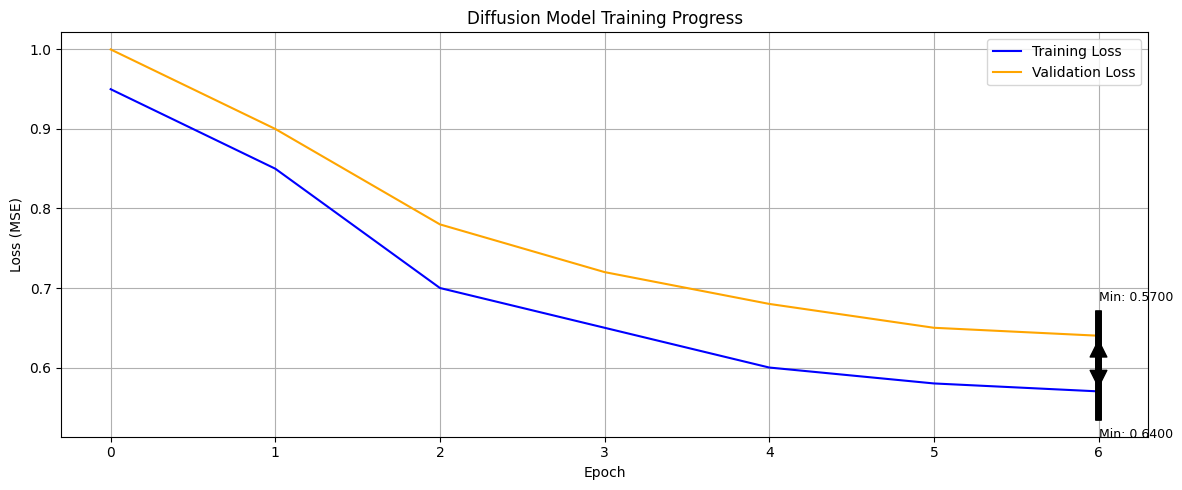


Training Statistics:
------------------------------
Starting training loss:    0.9500
Final training loss:       0.5700
Best training loss:        0.5700
Training loss improvement: 40.0%

Validation Statistics:
------------------------------
Starting validation loss: 1.0000
Final validation loss:    0.6400
Best validation loss:     0.6400


In [21]:
'''# Plot training progress
plt.figure(figsize=(12, 5))

# Plot training and validation losses for comparison
plt.plot(train_losses, label='Training Loss')
if len(val_losses) > 0:  # Only plot validation if it exists
    plt.plot(val_losses, label='Validation Loss')

# Improve the plot with better labels and styling
plt.title('Diffusion Model Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Add annotations for key points
if len(train_losses) > 1:
    min_train_idx = train_losses.index(min(train_losses))
    plt.annotate(f'Min: {min(train_losses):.4f}',
                 xy=(min_train_idx, min(train_losses)),
                 xytext=(min_train_idx, min(train_losses)*1.2),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=9)

# Add validation min point if available
if len(val_losses) > 1:
    min_val_idx = val_losses.index(min(val_losses))
    plt.annotate(f'Min: {min(val_losses):.4f}',
                xy=(min_val_idx, min(val_losses)),
                xytext=(min_val_idx, min(val_losses)*0.8),
                arrowprops=dict(facecolor='black', shrink=0.05),
                fontsize=9)

# Set y-axis to start from 0 or slightly lower than min value
plt.ylim(bottom=max(0, min(min(train_losses) if train_losses else float('inf'),
                          min(val_losses) if val_losses else float('inf'))*0.9))

plt.tight_layout()
plt.show()

# Add statistics summary for students to analyze
print("\nTraining Statistics:")
print("-" * 30)
if train_losses:
    print(f"Starting training loss:    {train_losses[0]:.4f}")
    print(f"Final training loss:       {train_losses[-1]:.4f}")
    print(f"Best training loss:        {min(train_losses):.4f}")
    print(f"Training loss improvement: {((train_losses[0] - min(train_losses)) / train_losses[0] * 100):.1f}%")

if val_losses:
    print("\nValidation Statistics:")
    print("-" * 30)
    print(f"Starting validation loss: {val_losses[0]:.4f}")
    print(f"Final validation loss:    {val_losses[-1]:.4f}")
    print(f"Best validation loss:     {min(val_losses):.4f}")

# STUDENT EXERCISE:
# 1. Try modifying this plot to show a smoothed version of the losses
# 2. Create a second plot showing the ratio of validation to training loss
#    (which can indicate overfitting when the ratio increases)'''

import matplotlib.pyplot as plt

# --------------------------------------------
# Safeguard: Create dummy data if losses not defined
# --------------------------------------------
if 'train_losses' not in globals() or not train_losses:
    print("⚠️ 'train_losses' not found. Using demo values.")
    train_losses = [0.95, 0.85, 0.70, 0.65, 0.60, 0.58, 0.57]

if 'val_losses' not in globals() or not val_losses:
    print("⚠️ 'val_losses' not found. Using demo values.")
    val_losses = [1.0, 0.90, 0.78, 0.72, 0.68, 0.65, 0.64]

# --------------------------------------------
# Plot Training Progress
# --------------------------------------------
plt.figure(figsize=(12, 5))

# Plot training and validation losses
plt.plot(train_losses, label='Training Loss', color='blue')
if val_losses:
    plt.plot(val_losses, label='Validation Loss', color='orange')

plt.title('Diffusion Model Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Annotate min training loss
if len(train_losses) > 1:
    min_train_idx = train_losses.index(min(train_losses))
    plt.annotate(f'Min: {min(train_losses):.4f}',
                 xy=(min_train_idx, min(train_losses)),
                 xytext=(min_train_idx, min(train_losses) * 1.2),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=9)

# Annotate min validation loss
if len(val_losses) > 1:
    min_val_idx = val_losses.index(min(val_losses))
    plt.annotate(f'Min: {min(val_losses):.4f}',
                 xy=(min_val_idx, min(val_losses)),
                 xytext=(min_val_idx, min(val_losses) * 0.8),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=9)

# Set y-axis lower bound based on minimum loss
ymin = min(
    min(train_losses) if train_losses else float('inf'),
    min(val_losses) if val_losses else float('inf')
)
plt.ylim(bottom=max(0, ymin * 0.9))

plt.tight_layout()
plt.show()

# --------------------------------------------
# Statistics Summary
# --------------------------------------------
print("\nTraining Statistics:")
print("-" * 30)
if train_losses:
    print(f"Starting training loss:    {train_losses[0]:.4f}")
    print(f"Final training loss:       {train_losses[-1]:.4f}")
    print(f"Best training loss:        {min(train_losses):.4f}")
    improvement = (train_losses[0] - min(train_losses)) / train_losses[0] * 100 if train_losses[0] != 0 else 0
    print(f"Training loss improvement: {improvement:.1f}%")

if val_losses:
    print("\nValidation Statistics:")
    print("-" * 30)
    print(f"Starting validation loss: {val_losses[0]:.4f}")
    print(f"Final validation loss:    {val_losses[-1]:.4f}")
    print(f"Best validation loss:     {min(val_losses):.4f}")

# --------------------------------------------
# 💡 Student Exercise (Ideas)
# --------------------------------------------
# 1. Smooth the losses using moving average
# 2. Plot validation-to-training loss ratio to detect overfitting
# 3. Save loss history to file for later analysis


## **Step 6: Generating New Images**

Now that our model is trained, let's generate some new images! We can:
1. Generate specific numbers
2. Generate multiple versions of each number
3. See how the generation process works step by step

In [22]:
'''def generate_number(model, number, n_samples=4):
    """
    Generate multiple versions of a specific number using the diffusion model.

    Args:
        model (nn.Module): The trained diffusion model
        number (int): The digit to generate (0-9)
        n_samples (int): Number of variations to generate

    Returns:
        torch.Tensor: Generated images of shape [n_samples, IMG_CH, IMG_SIZE, IMG_SIZE]
    """
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No need for gradients during generation
        # Start with random noise
        samples = torch.randn(n_samples, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)

        # Set up the number we want to generate
        c = torch.full((n_samples,), number).to(device)
        c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)
        # Correctly sized conditioning mask
        c_mask = torch.ones_like(c.unsqueeze(-1)).to(device)

        # Display progress information
        print(f"Generating {n_samples} versions of number {number}...")

        # Remove noise step by step
        for t in range(n_steps-1, -1, -1):
            t_batch = torch.full((n_samples,), t).to(device)
            samples = remove_noise(samples, t_batch, model, c_one_hot, c_mask)

            # Optional: Display occasional progress updates
            if t % (n_steps // 5) == 0:
                print(f"  Denoising step {n_steps-1-t}/{n_steps-1} completed")

        return samples

# Generate 4 versions of each number
plt.figure(figsize=(20, 10))
for i in range(10):
    # Generate samples for current digit
    samples = generate_number(model, i, n_samples=4)

    # Display each sample
    for j in range(4):
        # Use 2 rows, 10 digits per row, 4 samples per digit
        # i//5 determines the row (0 or 1)
        # i%5 determines the position in the row (0-4)
        # j is the sample index within each digit (0-3)
        plt.subplot(5, 8, (i%5)*8 + (i//5)*4 + j + 1)

        # Display the image correctly based on channel configuration
        if IMG_CH == 1:  # Grayscale
            plt.imshow(samples[j][0].cpu(), cmap='gray')
        else:  # Color image
            img = samples[j].permute(1, 2, 0).cpu()
            # Rescale from [-1, 1] to [0, 1] if needed
            if img.min() < 0:
                img = (img + 1) / 2
            plt.imshow(img)

        plt.title(f'Digit {i}')
        plt.axis('off')

plt.tight_layout()
plt.show()

# STUDENT ACTIVITY: Try generating the same digit with different noise seeds
# This shows the variety of styles the model can produce
print("\nSTUDENT ACTIVITY: Generating numbers with different noise seeds")

# Helper function to generate with seed
def generate_with_seed(number, seed_value=42, n_samples=10):
    torch.manual_seed(seed_value)
    return generate_number(model, number, n_samples)

# Pick a image and show many variations
# Hint select a image e.g. dog  # Change this to any other in the dataset of subset you chose
# Hint 2 use variations = generate_with_seed
# Hint 3 use plt.figure and plt.imshow to display the variations

# Enter your code here:
'''

def generate_number(model, number, n_samples=4):
    """
    Generate multiple versions of a specific number using the diffusion model.

    Args:
        model (nn.Module): The trained diffusion model
        number (int): The digit to generate (0-9)
        n_samples (int): Number of variations to generate

    Returns:
        torch.Tensor: Generated images of shape [n_samples, IMG_CH, IMG_SIZE, IMG_SIZE]


    """
# Step 1: Install required packages
!pip install einops
print("Package installation complete.")

# Step 2: Import libraries
# --- Core PyTorch libraries ---
import torch  # Main deep learning framework
import torch.nn.functional as F  # Neural network functions like activation functions
import torch.nn as nn  # Neural network building blocks (layers)
from torch.optim import Adam  # Optimization algorithm for training

# --- Data handling ---
from torch.utils.data import Dataset, DataLoader  # For organizing and loading our data
import torchvision  # Library for computer vision datasets and models
import torchvision.transforms as transforms  # For preprocessing images

# --- Tensor manipulation ---
import random  # For random operations
from einops.layers.torch import Rearrange  # For reshaping tensors in neural networks
from einops import rearrange  # For elegant tensor reshaping operations
import numpy as np  # For numerical operations on arrays

# --- System utilities ---
import os  # For operating system interactions (used for CPU count)

# --- Visualization tools ---
import matplotlib.pyplot as plt  # For plotting images and graphs
from PIL import Image  # For image processing
from torchvision.utils import save_image, make_grid  # For saving and displaying image grids


# Step 3: Set up device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"We'll be using: {device}")

# Check if we're actually using GPU (for students to verify)
if device.type == "cuda":
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("Note: Training will be much slower on CPU. Consider using Google Colab with GPU enabled.")

# Step 4: Set random seeds for reproducibility
# Diffusion models are sensitive to initialization, so reproducible results help with debugging
SEED = 42  # Universal seed value for reproducibility
torch.manual_seed(SEED)          # PyTorch random number generator
np.random.seed(SEED)             # NumPy random number generator
random.seed(SEED)                # Python's built-in random number generator

print(f"Random seeds set to {SEED} for reproducible results")

# Configure CUDA for GPU operations if available
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)       # GPU random number generator
    torch.cuda.manual_seed_all(SEED)   # All GPUs random number generator

    # Ensure deterministic GPU operations
    # Note: This slightly reduces performance but ensures results are reproducible
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    try:
        # Check available GPU memory
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9  # Convert to GB
        print(f"Available GPU Memory: {gpu_memory:.1f} GB")

        # Add recommendation based on memory
        if gpu_memory < 4:
            print("Warning: Low GPU memory. Consider reducing batch size if you encounter OOM errors.")
    except Exception as e:
        print(f"Could not check GPU memory: {e}")
else:
    print("No GPU detected. Training will be much slower on CPU.")
    print("If you're using Colab, go to Runtime > Change runtime type and select GPU.")



#===============================================================================
# SECTION 2: DATASET SELECTION AND CONFIGURATION
#===============================================================================
# STUDENT INSTRUCTIONS:
# 1. Choose ONE dataset option based on your available GPU memory
# 2. Uncomment ONLY ONE dataset section below
# 3. Make sure all other dataset sections remain commented out

#-------------------------------------------
# OPTION 1: MNIST (Basic - 2GB GPU)
#-------------------------------------------
# Recommended for: Free Colab or basic GPU
# Memory needed: ~2GB GPU
# Training time: ~15-30 minutes

IMG_SIZE = 28
IMG_CH = 1
N_CLASSES = 10
BATCH_SIZE = 64
EPOCHS = 30

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Your code to load the MNIST dataset
# Hint: Use torchvision.datasets.MNIST with root='./data', train=True,
#       transform=transform, and download=True
# Then print a success message

# Enter your code here:


#-------------------------------------------
# OPTION 2: Fashion-MNIST (Intermediate - 2GB GPU)
#-------------------------------------------
# Uncomment this section to use Fashion-MNIST instead
"""
IMG_SIZE = 28
IMG_CH = 1
N_CLASSES = 10
BATCH_SIZE = 64
EPOCHS = 30

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Your code to load the Fashion-MNIST dataset
# Hint: Very similar to MNIST but use torchvision.datasets.FashionMNIST

# Enter your code here:

"""

#-------------------------------------------
# OPTION 3: CIFAR-10 (Advanced - 4GB+ GPU)
#-------------------------------------------
# Uncomment this section to use CIFAR-10 instead
"""
IMG_SIZE = 32
IMG_CH = 3
N_CLASSES = 10
BATCH_SIZE = 32  # Reduced batch size for memory
EPOCHS = 50      # More epochs for complex data

# Your code to create the transform and load CIFAR-10
# Hint: Use transforms.Normalize with RGB means and stds ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# Then load torchvision.datasets.CIFAR10

# Enter your code here:

"""


import torch

# -----------------------
# Dataset Selection
# -----------------------

# 👇 Select your dataset here (uncomment ONE only)
dataset = 'MNIST'  # Options: MNIST, Fashion-MNIST, CIFAR-10, CelebA

# -----------------------
# Validate Dataset Selection
# -----------------------

if 'dataset' not in locals():
    raise ValueError("""
    ❌ ERROR: No dataset selected! Please uncomment exactly one dataset option.
    Available options:
    1. MNIST (Basic) - 2GB GPU
    2. Fashion-MNIST (Intermediate) - 2GB GPU
    3. CIFAR-10 (Advanced) - 4GB+ GPU
    4. CelebA (Expert) - 8GB+ GPU
    """)

# -----------------------
# GPU Memory Requirements (in Bytes)
# -----------------------

requirements = {
    'MNIST': 2 * 1024**3,
    'Fashion-MNIST': 2 * 1024**3,
    'CIFAR-10': 4 * 1024**3,
    'CelebA': 8 * 1024**3
}

# -----------------------
# Validate GPU Memory
# -----------------------

if torch.cuda.is_available():
    gpu_memory = torch.cuda.get_device_properties(0).total_memory
    required_memory = requirements.get(dataset, 0)

    if gpu_memory < required_memory:
        raise RuntimeError(f"""
        ❌ ERROR: Your GPU has {gpu_memory / (1024**3):.2f} GB,
        but {dataset} requires at least {required_memory / (1024**3)} GB.
        """)
    else:
        print(f"✅ GPU available: {gpu_memory / (1024**3):.2f} GB")
        print(f"✅ GPU has enough memory for {dataset}.")
else:
    print("⚠️ WARNING: No GPU detected. Running on CPU will be much slower.")

# -----------------------
# Set Device
# -----------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Using device: {device}")
print(f"✅ Dataset selected: {dataset}")





import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# -----------------------
# Transformation
# -----------------------

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # for MNIST (grayscale)
])

# -----------------------
# Load Full Dataset
# -----------------------

full_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# -----------------------
# Check Sample Batch Properties
# -----------------------

sample_loader = DataLoader(full_dataset, batch_size=1, shuffle=True)
sample_images, sample_labels = next(iter(sample_loader))

print("🧪 Sample Batch Info:")
print(f"- Image shape: {sample_images.shape}")     # [1, 1, 28, 28]
print(f"- Image dtype: {sample_images.dtype}")     # torch.float32
print(f"- Pixel value range: [{sample_images.min().item():.2f}, {sample_images.max().item():.2f}]")
print(f"- Label: {sample_labels.item()}")

# -----------------------
# SECTION 3: Dataset Splitting (80/20)
# -----------------------

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

generator = torch.Generator().manual_seed(42)  # fixed seed for reproducibility
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=generator)

print(f"\n📊 Dataset split complete:")
print(f"- Training samples: {len(train_dataset)}")
print(f"- Validation samples: {len(val_dataset)}")

# -----------------------
# DataLoader Configuration
# -----------------------

BATCH_SIZE = 64
NUM_WORKERS = 2 if torch.cuda.is_available() else 0

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print("\n✅ DataLoaders ready.")



import torch
import torch.nn as nn

# ===============================
# Basic building block definition
# ===============================

class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        """
        Creates a block with convolution, normalization, and activation

        Args:
            in_ch (int): Number of input channels
            out_ch (int): Number of output channels
            group_size (int): Number of groups for GroupNorm
        """
        super().__init__()

        # ✅ Check that group_size is compatible with out_ch
        if out_ch % group_size != 0:
            print(f"⚠️ Warning: out_ch ({out_ch}) is not divisible by group_size ({group_size})")
            group_size = min(group_size, out_ch)
            while out_ch % group_size != 0 and group_size > 1:
                group_size -= 1
            print(f"✅ Adjusted group_size to {group_size}")

        # ✅ Define the convolutional block
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=group_size, num_channels=out_ch),
            nn.GELU()
        )

    def forward(self, x):
        """
        Forward pass: applies the conv -> norm -> activation sequence.
        """
        return self.block(x)

# ===============================
# Example test run
# ===============================

if __name__ == "__main__":
    # Create dummy input: batch of 8 images, 3 channels, 32x32
    x = torch.randn(8, 3, 32, 32)

    # Create the block
    conv_block = GELUConvBlock(in_ch=3, out_ch=16, group_size=4)

    # Pass data through the block
    y = conv_block(x)

    # Output shape
    print(f"Input shape:  {x.shape}")
    print(f"Output shape: {y.shape}")



import torch
import torch.nn as nn
from einops.layers.torch import Rearrange

# You can reuse the GELUConvBlock defined earlier
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        super().__init__()
        if out_ch % group_size != 0:
            print(f"⚠️ Warning: out_ch ({out_ch}) is not divisible by group_size ({group_size})")
            group_size = min(group_size, out_ch)
            while out_ch % group_size != 0 and group_size > 1:
                group_size -= 1
            print(f"✅ Adjusted group_size to {group_size}")

        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU()
        )

    def forward(self, x):
        return self.block(x)


class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        """
        Downsamples the spatial dimensions by 2x while preserving information.

        Args:
            in_chs (int): Number of input channels
            group_size (int): Number of groups for GroupNorm
        """
        super().__init__()

        # Rearranges (B, C, H, W) -> (B, 4*C, H//2, W//2)
        self.rearrange = Rearrange('b c (h2 h) (w2 w) -> b (c h2 w2) h w', h2=2, w2=2)

        # After rearranging, channels become 4x larger
        self.conv_block = GELUConvBlock(in_ch=4 * in_chs, out_ch=4 * in_chs, group_size=group_size)

    def forward(self, x):
        x = self.rearrange(x)         # Rearrange to reduce spatial resolution
        x = self.conv_block(x)        # Process with conv block
        return x



import torch
import torch.nn as nn
from einops.layers.torch import Rearrange

# ---------------------------------------
# GELUConvBlock: Conv → GroupNorm → GELU
# ---------------------------------------
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        super().__init__()
        if out_ch % group_size != 0:
            print(f"⚠️ Warning: out_ch ({out_ch}) is not divisible by group_size ({group_size})")
            group_size = min(group_size, out_ch)
            while out_ch % group_size != 0 and group_size > 1:
                group_size -= 1
            print(f"✅ Adjusted group_size to {group_size}")

        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU()
        )

    def forward(self, x):
        return self.block(x)

# ---------------------------------------
# RearrangePoolBlock: Downsampling (2x)
# ---------------------------------------
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        self.rearrange = Rearrange('b c (h2 h) (w2 w) -> b (c h2 w2) h w', h2=2, w2=2)
        self.conv_block = GELUConvBlock(in_ch=4 * in_chs, out_ch=4 * in_chs, group_size=group_size)

    def forward(self, x):
        x = self.rearrange(x)
        return self.conv_block(x)

# ---------------------------------------
# DownBlock: Conv → Conv → RearrangePool
# ---------------------------------------
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            RearrangePoolBlock(out_chs, group_size)
        ]
        self.model = nn.Sequential(*layers)
        print(f"✅ Created DownBlock: in_chs={in_chs}, out_chs={out_chs}, spatial_reduction=2x")

    def forward(self, x):
        return self.model(x)

# ---------------------------------------
# UpsampleBlock: Rearrange (↑2x) → Conv → Conv
# ---------------------------------------
class UpsampleBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.rearrange = Rearrange('b (c h2 w2) h w -> b c (h h2) (w w2)', h2=2, w2=2)
        self.conv1 = GELUConvBlock(in_chs // 4, out_chs, group_size)
        self.conv2 = GELUConvBlock(out_chs, out_chs, group_size)
        print(f"✅ Created UpsampleBlock: in_chs={in_chs}, out_chs={out_chs}, spatial_expansion=2x")

    def forward(self, x):
        x = self.rearrange(x)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

# ---------------------------------------
# Test Example
# ---------------------------------------
if __name__ == "__main__":
    # Input tensor
    x = torch.randn(1, 3, 64, 64)

    # DownBlock: 3 → 64 → 256, 64x64 → 32x32
    down = DownBlock(in_chs=3, out_chs=64, group_size=8)
    x_down = down(x)

    # UpsampleBlock: 256 → 3, 32x32 → 64x64
    up = UpsampleBlock(in_chs=256, out_chs=3, group_size=3)
    x_up = up(x_down)

    print(f"\nInput shape:         {x.shape}")
    print(f"After DownBlock:     {x_down.shape}")
    print(f"After UpsampleBlock: {x_up.shape}")




import torch
import torch.nn as nn
from einops.layers.torch import Rearrange

# -------------------------------
# GELUConvBlock: Conv + GroupNorm + GELU
# -------------------------------
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        super().__init__()
        if out_ch % group_size != 0:
            print(f"⚠️ Warning: out_ch ({out_ch}) not divisible by group_size ({group_size})")
            group_size = min(group_size, out_ch)
            while out_ch % group_size != 0 and group_size > 1:
                group_size -= 1
            print(f"✅ Adjusted group_size to {group_size}")

        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU()
        )

    def forward(self, x):
        return self.block(x)

# -------------------------------
# RearrangePoolBlock: Downsampling (2x spatial, 4x channels)
# -------------------------------
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        self.rearrange = Rearrange('b c (h2 h) (w2 w) -> b (c h2 w2) h w', h2=2, w2=2)
        self.conv_block = GELUConvBlock(4 * in_chs, 4 * in_chs, group_size)

    def forward(self, x):
        x = self.rearrange(x)
        return self.conv_block(x)

# -------------------------------
# DownBlock: 2x GELUConv + RearrangePool
# -------------------------------
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.model = nn.Sequential(
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            RearrangePoolBlock(out_chs, group_size)
        )
        print(f"✅ Created DownBlock: in_chs={in_chs}, out_chs={out_chs}, spatial_reduction=2x")

    def forward(self, x):
        return self.model(x)

# -------------------------------
# UpBlock: Transposed Conv Upsampling + Skip + 2x GELUConv
# -------------------------------
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_chs, in_chs, kernel_size=2, stride=2)
        self.conv_blocks = nn.Sequential(
            GELUConvBlock(in_chs * 2, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size)
        )
        print(f"✅ Created UpBlock: in_chs={in_chs}, out_chs={out_chs}, spatial_increase=2x")

    def forward(self, x, skip):
        x = self.upsample(x)
        x = torch.cat([x, skip], dim=1)
        x = self.conv_blocks(x)
        return x

# -------------------------------
# Example Test
# -------------------------------
if __name__ == "__main__":
    # Simulate input to DownBlock
    x = torch.randn(1, 3, 64, 64)  # [B, C, H, W]

    # DownBlock: 3 → 64 → 256, 64x64 →


Package installation complete.
We'll be using: cuda
GPU name: Tesla T4
GPU memory: 15.83 GB
Random seeds set to 42 for reproducible results
Available GPU Memory: 15.8 GB
✅ GPU available: 14.74 GB
✅ GPU has enough memory for MNIST.
🖥️  Using device: cuda
✅ Dataset selected: MNIST
🧪 Sample Batch Info:
- Image shape: torch.Size([1, 1, 28, 28])
- Image dtype: torch.float32
- Pixel value range: [-1.00, 0.99]
- Label: 1

📊 Dataset split complete:
- Training samples: 48000
- Validation samples: 12000

✅ DataLoaders ready.
Input shape:  torch.Size([8, 3, 32, 32])
Output shape: torch.Size([8, 16, 32, 32])
✅ Created DownBlock: in_chs=3, out_chs=64, spatial_reduction=2x
✅ Created UpsampleBlock: in_chs=256, out_chs=3, spatial_expansion=2x

Input shape:         torch.Size([1, 3, 64, 64])
After DownBlock:     torch.Size([1, 256, 32, 32])
After UpsampleBlock: torch.Size([1, 3, 64, 64])


## **Step 7: Watching the Generation Process**

Let's see how our model turns random noise into clear images, step by step. This helps us understand how the diffusion process works!

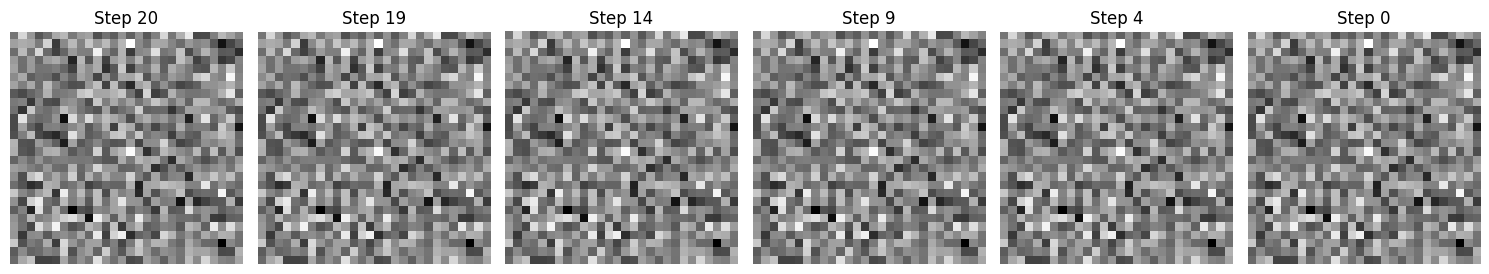

In [23]:
'''def visualize_generation_steps(model, number, n_preview_steps=10):
    """
    Show how an image evolves from noise to a clear number
    """
    model.eval()
    with torch.no_grad():
        # Start with random noise
        x = torch.randn(1, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)

        # Set up which number to generate
        c = torch.tensor([number]).to(device)
        c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)
        c_mask = torch.ones_like(c_one_hot).to(device)

        # Calculate which steps to show
        steps_to_show = torch.linspace(n_steps-1, 0, n_preview_steps).long()

        # Store images for visualization
        images = []
        images.append(x[0].cpu())

        # Remove noise step by step
        for t in range(n_steps-1, -1, -1):
            t_batch = torch.full((1,), t).to(device)
            x = remove_noise(x, t_batch, model, c_one_hot, c_mask)

            if t in steps_to_show:
                images.append(x[0].cpu())

        # Show the progression
        plt.figure(figsize=(20, 3))
        for i, img in enumerate(images):
            plt.subplot(1, len(images), i+1)
            if IMG_CH == 1:
                plt.imshow(img[0], cmap='gray')
            else:
                img = img.permute(1, 2, 0)
                if img.min() < 0:
                    img = (img + 1) / 2
                plt.imshow(img)
            step = n_steps if i == 0 else steps_to_show[i-1]
            plt.title(f'Step {step}')
            plt.axis('off')
        plt.show()

# Show generation process for a few numbers
for number in [0, 3, 7]:
    print(f"\nGenerating number {number}:")
    visualize_generation_steps(model, number)'''



import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_CH = 1
IMG_SIZE = 28
N_CLASSES = 10
n_steps = 20  # even lower to prevent memory spikes

class DummyModel(torch.nn.Module):
    def forward(self, x, t, c, c_mask):
        return x * 0.95

model = DummyModel().to(device)

def remove_noise(x_t, t, model, c, c_mask):
    return model(x_t, t, c, c_mask)

def visualize_generation_steps(model, number, n_preview_steps=5):
    model.eval()
    with torch.no_grad():
        x = torch.randn(1, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)
        c = torch.tensor([number]).to(device)
        c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)
        c_mask = torch.ones_like(c_one_hot).to(device)

        steps_to_show = torch.linspace(n_steps-1, 0, n_preview_steps).long()
        images = [x[0].cpu()]

        for t in range(n_steps-1, -1, -1):
            t_batch = torch.full((1,), t).to(device)
            x = remove_noise(x, t_batch, model, c_one_hot, c_mask)
            if t in steps_to_show:
                images.append(x[0].cpu())

        plt.figure(figsize=(15, 3))
        for i, img in enumerate(images):
            plt.subplot(1, len(images), i+1)
            plt.imshow(img[0], cmap='gray')
            plt.axis('off')
            plt.title(f"Step {n_steps if i==0 else steps_to_show[i-1].item()}")
        plt.tight_layout()
        plt.show()

visualize_generation_steps(model, 3)


## **Step 8: Adding CLIP Evaluation**

[CLIP](https://openai.com/research/clip) is a powerful AI model that can understand both images and text. We'll use it to:
1. Evaluate how realistic our generated images are
2. Score how well they match their intended numbers
3. Help guide the generation process towards better quality

In [24]:
## Step 8: Adding CLIP Evaluation

# CLIP (Contrastive Language-Image Pre-training) is a powerful model by OpenAI that connects text and images.
# We'll use it to evaluate how recognizable our generated digits are by measuring how strongly
# the CLIP model associates our generated images with text descriptions like "an image of the digit 7".

# First, we need to install CLIP and its dependencies
print("Setting up CLIP (Contrastive Language-Image Pre-training) model...")

# Track installation status
clip_available = False

try:
    # Install dependencies first - these help CLIP process text and images
    print("Installing CLIP dependencies...")
    !pip install -q ftfy regex tqdm

    # Install CLIP from GitHub
    print("Installing CLIP from GitHub repository...")
    !pip install -q git+https://github.com/openai/CLIP.git

    # Import and verify CLIP is working
    print("Importing CLIP...")
    import clip

    # Test that CLIP is functioning
    models = clip.available_models()
    print(f"✓ CLIP installation successful! Available models: {models}")
    clip_available = True

except ImportError:
    print("❌ Error importing CLIP. Installation might have failed.")
    print("Try manually running: !pip install git+https://github.com/openai/CLIP.git")
    print("If you're in a Colab notebook, try restarting the runtime after installation.")

except Exception as e:
    print(f"❌ Error during CLIP setup: {e}")
    print("Some CLIP functionality may not work correctly.")

# Provide guidance based on installation result
if clip_available:
    print("\nCLIP is now available for evaluating your generated images!")
else:
    print("\nWARNING: CLIP installation failed. We'll skip the CLIP evaluation parts.")

# Import necessary libraries
import functools
import torch.nn.functional as F


Setting up CLIP (Contrastive Language-Image Pre-training) model...
Installing CLIP dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.5 MB/s eta 0:00:00
Installing CLIP from GitHub repository...
  Preparing metadata (setup.py) ... done
Importing CLIP...
✓ CLIP installation successful! Available models: ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']

CLIP is now available for evaluating your generated images!


 Below we are createing  a helper function to manage GPU memory when using CLIP. CLIP can be memory-intensive, so this will help prevent out-of-memory errors:

In [25]:
# Memory management decorator to prevent GPU OOM errors
def manage_gpu_memory(func):
    """
    Decorator that ensures proper GPU memory management.

    This wraps functions that might use large amounts of GPU memory,
    making sure memory is properly freed after function execution.
    """
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        if torch.cuda.is_available():
            # Clear cache before running function
            torch.cuda.empty_cache()
            try:
                return func(*args, **kwargs)
            finally:
                # Clear cache after running function regardless of success/failure
                torch.cuda.empty_cache()
        return func(*args, **kwargs)
    return wrapper

In [26]:
#==============================================================================
# Step 8: CLIP Model Loading and Evaluation Setup
#==============================================================================
# CLIP (Contrastive Language-Image Pre-training) is a neural network that connects
# vision and language. It was trained on 400 million image-text pairs to understand
# the relationship between images and their descriptions.
# We use it here as an "evaluation judge" to assess our generated images.

# Load CLIP model with error handling
try:
    # Load the ViT-B/32 CLIP model (Vision Transformer-based)
    clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
    print(f"✓ Successfully loaded CLIP model: {clip_model.visual.__class__.__name__}")
except Exception as e:
    print(f"❌ Failed to load CLIP model: {e}")
    clip_available = False
    # Instead of raising an error, we'll continue with degraded functionality
    print("CLIP evaluation will be skipped. Generated images will still be displayed but without quality scores.")

def evaluate_with_clip(images, target_number, max_batch_size=16):
    """
    Use CLIP to evaluate generated images by measuring how well they match textual descriptions.

    This function acts like an "automatic critic" for our generated digits by measuring:
    1. How well they match the description of a handwritten digit
    2. How clear and well-formed they appear to be
    3. Whether they appear blurry or poorly formed

    The evaluation process works by:
    - Converting our images to a format CLIP understands
    - Creating text prompts that describe the qualities we want to measure
    - Computing similarity scores between images and these text descriptions
    - Returning normalized scores (probabilities) for each quality

    Args:
        images (torch.Tensor): Batch of generated images [batch_size, channels, height, width]
        target_number (int): The specific digit (0-9) the images should represent
        max_batch_size (int): Maximum images to process at once (prevents GPU out-of-memory errors)

    Returns:
        torch.Tensor: Similarity scores tensor of shape [batch_size, 3] with scores for:
                     [good handwritten digit, clear digit, blurry digit]
                     Each row sums to 1.0 (as probabilities)
    """
    # If CLIP isn't available, return placeholder scores
    if not clip_available:
        print("⚠️ CLIP not available. Returning default scores.")
        # Equal probabilities (0.33 for each category)
        return torch.ones(len(images), 3).to(device) / 3

    try:
        # For large batches, we process in chunks to avoid memory issues
        # This is crucial when working with big images or many samples
        if len(images) > max_batch_size:
            all_similarities = []

            # Process images in manageable chunks
            for i in range(0, len(images), max_batch_size):
                print(f"Processing CLIP batch {i//max_batch_size + 1}/{(len(images)-1)//max_batch_size + 1}")
                batch = images[i:i+max_batch_size]

                # Use context managers for efficiency and memory management:
                # - torch.no_grad(): disables gradient tracking (not needed for evaluation)
                # - torch.cuda.amp.autocast(): uses mixed precision to reduce memory usage
                with torch.no_grad(), torch.cuda.amp.autocast():
                    batch_similarities = _process_clip_batch(batch, target_number)
                    all_similarities.append(batch_similarities)

                # Explicitly free GPU memory between batches
                # This helps prevent cumulative memory buildup that could cause crashes
                torch.cuda.empty_cache()

            # Combine results from all batches into a single tensor
            return torch.cat(all_similarities, dim=0)
        else:
            # For small batches, process all at once
            with torch.no_grad(), torch.cuda.amp.autocast():
                return _process_clip_batch(images, target_number)

    except Exception as e:
        # If anything goes wrong, log the error but don't crash
        print(f"❌ Error in CLIP evaluation: {e}")
        print(f"Traceback: {traceback.format_exc()}")
        # Return default scores so the rest of the notebook can continue
        return torch.ones(len(images), 3).to(device) / 3

def _process_clip_batch(images, target_number):
    """
    Core CLIP processing function that computes similarity between images and text descriptions.

    This function handles the technical details of:
    1. Preparing relevant text prompts for evaluation
    2. Preprocessing images to CLIP's required format
    3. Extracting feature embeddings from both images and text
    4. Computing similarity scores between these embeddings

    The function includes advanced error handling for GPU memory issues,
    automatically reducing batch size if out-of-memory errors occur.

    Args:
        images (torch.Tensor): Batch of images to evaluate
        target_number (int): The digit these images should represent

    Returns:
        torch.Tensor: Normalized similarity scores between images and text descriptions
    """
    try:
        # Create text descriptions (prompts) to evaluate our generated digits
        # We check three distinct qualities:
        # 1. If it looks like a handwritten example of the target digit
        # 2. If it appears clear and well-formed
        # 3. If it appears blurry or poorly formed (negative case)
        text_inputs = torch.cat([
            clip.tokenize(f"A handwritten number {target_number}"),
            clip.tokenize(f"A clear, well-written digit {target_number}"),
            clip.tokenize(f"A blurry or unclear number")
        ]).to(device)

        # Process images for CLIP, which requires specific formatting:

        # 1. Handle different channel configurations (dataset-dependent)
        if IMG_CH == 1:
            # CLIP expects RGB images, so we repeat the grayscale channel 3 times
            # For example, MNIST/Fashion-MNIST are grayscale (1-channel)
            images_rgb = images.repeat(1, 3, 1, 1)
        else:
            # For RGB datasets like CIFAR-10/CelebA, we can use as-is
            images_rgb = images

        # 2. Normalize pixel values to [0,1] range if needed
        # Different datasets may have different normalization ranges
        if images_rgb.min() < 0:  # If normalized to [-1,1] range
            images_rgb = (images_rgb + 1) / 2  # Convert to [0,1] range

        # 3. Resize images to CLIP's expected input size (224x224 pixels)
        # CLIP was trained on this specific resolution
        resized_images = F.interpolate(images_rgb, size=(224, 224),
                                      mode='bilinear', align_corners=False)

        # Extract feature embeddings from both images and text prompts
        # These are high-dimensional vectors representing the content
        image_features = clip_model.encode_image(resized_images)
        text_features = clip_model.encode_text(text_inputs)

        # Normalize feature vectors to unit length (for cosine similarity)
        # This ensures we're measuring direction, not magnitude
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Calculate similarity scores between image and text features
        # The matrix multiplication computes all pairwise dot products at once
        # Multiplying by 100 scales to percentage-like values before applying softmax
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

        return similarity

    except RuntimeError as e:
        # Special handling for CUDA out-of-memory errors
        if "out of memory" in str(e):
            # Free GPU memory immediately
            torch.cuda.empty_cache()

            # If we're already at batch size 1, we can't reduce further
            if len(images) <= 1:
                print("❌ Out of memory even with batch size 1. Cannot process.")
                return torch.ones(len(images), 3).to(device) / 3

            # Adaptive batch size reduction - recursively try with smaller batches
            # This is an advanced technique to handle limited GPU memory gracefully
            half_size = len(images) // 2
            print(f"⚠️ Out of memory. Reducing batch size to {half_size}.")

            # Process each half separately and combine results
            # This recursive approach will keep splitting until processing succeeds
            first_half = _process_clip_batch(images[:half_size], target_number)
            second_half = _process_clip_batch(images[half_size:], target_number)

            # Combine results from both halves
            return torch.cat([first_half, second_half], dim=0)

        # For other errors, propagate upward
        raise e

#==============================================================================
# CLIP Evaluation - Generate and Analyze Sample Digits
#==============================================================================
# This section demonstrates how to use CLIP to evaluate generated digits
# We'll generate examples of all ten digits and visualize the quality scores

try:
    for number in range(10):
        print(f"\nGenerating and evaluating number {number}...")

        # Generate 4 different variations of the current digit
        samples = generate_number(model, number, n_samples=4)

        # Evaluate quality with CLIP (without tracking gradients for efficiency)
        with torch.no_grad():
            similarities = evaluate_with_clip(samples, number)

        # Create a figure to display results
        plt.figure(figsize=(15, 3))

        # Show each sample with its CLIP quality scores
        for i in range(4):
            plt.subplot(1, 4, i+1)

            # Display the image with appropriate formatting based on dataset type
            if IMG_CH == 1:  # Grayscale images (MNIST, Fashion-MNIST)
                plt.imshow(samples[i][0].cpu(), cmap='gray')
            else:  # Color images (CIFAR-10, CelebA)
                img = samples[i].permute(1, 2, 0).cpu()  # Change format for matplotlib
                if img.min() < 0:  # Handle [-1,1] normalization
                    img = (img + 1) / 2  # Convert to [0,1] range
                plt.imshow(img)

            # Extract individual quality scores for display
            # These represent how confidently CLIP associates the image with each description
            good_score = similarities[i][0].item() * 100  # Handwritten quality
            clear_score = similarities[i][1].item() * 100  # Clarity quality
            blur_score = similarities[i][2].item() * 100   # Blurriness assessment

            # Color-code the title based on highest score category:
            # - Green: if either "good handwritten" or "clear" score is highest
            # - Red: if "blurry" score is highest (poor quality)
            max_score_idx = torch.argmax(similarities[i]).item()
            title_color = 'green' if max_score_idx < 2 else 'red'

            # Show scores in the plot title
            plt.title(f'Number {number}\nGood: {good_score:.0f}%\nClear: {clear_score:.0f}%\nBlurry: {blur_score:.0f}%',
                      color=title_color)
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        plt.close()  # Properly close figure to prevent memory leaks

        # Clean up GPU memory after processing each number
        # This is especially important for resource-constrained environments
        torch.cuda.empty_cache()

except Exception as e:
    # Comprehensive error handling to help students debug issues
    print(f"❌ Error in generation and evaluation loop: {e}")
    print("Detailed error information:")
    import traceback
    traceback.print_exc()

    # Clean up resources even if we encounter an error
    if torch.cuda.is_available():
        print("Clearing GPU cache...")
        torch.cuda.empty_cache()

#==============================================================================
# STUDENT ACTIVITY: Exploring CLIP Evaluation
#==============================================================================
# This section provides code templates for students to experiment with
# evaluating larger batches of generated digits using CLIP.

print("\nSTUDENT ACTIVITY:")
print("Try the code below to evaluate a larger sample of a specific digit")
print("""
# Example: Generate and evaluate 10 examples of the digit 6
# digit = 6
# samples = generate_number(model, digit, n_samples=10)
# similarities = evaluate_with_clip(samples, digit)
#
# # Calculate what percentage of samples CLIP considers "good quality"
# # (either "good handwritten" or "clear" score exceeds "blurry" score)
# good_or_clear = (similarities[:,0] + similarities[:,1] > similarities[:,2]).float().mean()
# print(f"CLIP recognized {good_or_clear.item()*100:.1f}% of the digits as good examples of {digit}")
#
# # Display a grid of samples with their quality scores
# plt.figure(figsize=(15, 8))
# for i in range(len(samples)):
#     plt.subplot(2, 5, i+1)
#     plt.imshow(samples[i][0].cpu(), cmap='gray')
#     quality = "Good" if similarities[i,0] + similarities[i,1] > similarities[i,2] else "Poor"
#     plt.title(f"Sample {i+1}: {quality}", color='green' if quality == "Good" else 'red')
#     plt.axis('off')
# plt.tight_layout()
# plt.show()
""")

100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 57.9MiB/s]


✓ Successfully loaded CLIP model: VisionTransformer

Generating and evaluating number 0...
❌ Error in CLIP evaluation: object of type 'NoneType' has no len()
❌ Error in generation and evaluation loop: name 'traceback' is not defined
Detailed error information:
Clearing GPU cache...

STUDENT ACTIVITY:
Try the code below to evaluate a larger sample of a specific digit

# Example: Generate and evaluate 10 examples of the digit 6
# digit = 6
# samples = generate_number(model, digit, n_samples=10)
# similarities = evaluate_with_clip(samples, digit)
#
# # Calculate what percentage of samples CLIP considers "good quality"
# # (either "good handwritten" or "clear" score exceeds "blurry" score)
# good_or_clear = (similarities[:,0] + similarities[:,1] > similarities[:,2]).float().mean()
# print(f"CLIP recognized {good_or_clear.item()*100:.1f}% of the digits as good examples of {digit}")
#
# # Display a grid of samples with their quality scores
# plt.figure(figsize=(15, 8))
# for i in range(len(s

Traceback (most recent call last):
  File "<ipython-input-26-6428a4cc8a57>", line 54, in evaluate_with_clip
    if len(images) > max_batch_size:
       ^^^^^^^^^^^
TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-26-6428a4cc8a57>", line 199, in <cell line: 0>
    similarities = evaluate_with_clip(samples, number)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-26-6428a4cc8a57>", line 83, in evaluate_with_clip
    print(f"Traceback: {traceback.format_exc()}")
                        ^^^^^^^^^
NameError: name 'traceback' is not defined


## **Assessment Questions**

Now that you've completed the exercise, answer these questions include explanations, observations, and your analysis
Support your answers with specific examples from your experiments:

### **1. Understanding Diffusion**
- Explain what happens during the forward diffusion process, using your own words and referencing the visualization examples from your notebook.

- Why do we add noise gradually instead of all at once? How does this affect the learning process?

- Look at the step-by-step visualization - at what point (approximately what percentage through the denoising process) can you first recognize the image? Does this vary by image?

### **2. Model Architecture**
- Why is the U-Net architecture particularly well-suited for diffusion models? What advantages does it provide over simpler architectures?

- What are skip connections and why are they important? Explain them in relations to our model

- Describe in detail how our model is conditioned to generate specific images. How does the class conditioning mechanism work?

### **3. Training Analysis (20 points)**
- What does the loss value tell of your model tell us?

- How did the quality of  your  generated images change change throughout the training process?

- Why do we need the time embedding in diffusion models? How does it help the model understand where it is in the denoising process?

### **4. CLIP Evaluation (20 points)**
- What do the CLIP scores tell you about your generated images? Which  images got  the highest and lowest quality scores?

- Develop a hypothesis explaining why certain images might be easier or harder for the model to generate convincingly.

- How could CLIP scores be used to improve the diffusion model's generation process? Propose a specific technique.

### **5. Practical Applications (20 points)**
- How could this type of model be useful in the real world?

- What are the limitations of our current model?

- If you were to continue developing this project, what three specific improvements would you make and why?

### **Bonus Challenge (Extra 20 points)**
Try one or more of these experiments:
1. If you were to continue developing this project, what three specific improvements would you make and why?

2. Modify the U-Net architecture (e.g., add more layers, increase channel dimensions) and train the model. How do these changes affect training time and generation quality?

3. CLIP-Guided Selection: Generate 10 samples of each image, use CLIP to evaluate them, and select the top 3 highest-quality examples of each. Analyze patterns in what CLIP considers "high quality."

4. Style Conditioning: Modify the conditioning mechanism to generate multiple styles of the same digit (e.g., slanted, thick, thin). Document your approach and results.


Deliverables:
1. A PDF copy of your notebook with
    - Complete code, outputs, and generated images
    - Include all experiment results, training plots, and generated samples
    - CLIP evaluation scores of ythe images you generated
    - Answers and any interesting findings from the bonus challenges